# 초기세팅

In [6]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 통계 분석
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, chi2_contingency, f_oneway
from scipy.stats import mannwhitneyu, fisher_exact, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import ast
# import pingouin as pg
# import scikit_posthocs as sp

# 출력 설정
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 시드 설정
np.random.seed(42)

print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("="*60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


# 전처리

### 데이터셋 호출 및 전처리

In [7]:
# 아이템,챔프 정보 데이터셋 호출
df = pd.read_csv('TFT_Match_info.csv',index_col=0)

#아이템,챔프 정보 데이터셋 호출 (파일 구분 쉽게용)
df_champ = pd.read_csv('TFT_Champion.csv')
df_item  = pd.read_csv('TFT_Item.csv')

# 아이템,챔프 정보 데이터셋 호출 (정식코드)
#df_champ = pd.read_csv('TFT_Champion_CurrentVersion.csv')
#df_item  = pd.read_csv('TFT_Item_CurrentVersion.csv')

# 티어 컬럼 이동
col = df.pop('tier')
df.insert(5, 'tier', col)

### 챔피언 코스트 호출

In [8]:
#챔프 정보 데이터셋 호출
df_champ = pd.read_csv('TFT_Champion.csv')

# 챔피언 데이터 셋에서 이름 호출 및 대소문자 변환
df_champ['name'] = df_champ['name'].str.title()

# {name : cost} 딕셔너리화
champ_cost = df_champ.set_index('name')['cost'].to_dict()

print(champ_cost)

{'Gangplank': 5, 'Graves': 1, 'Neeko': 3, 'Darius': 2, 'Rakan': 2, 'Lux': 3, 'Rumble': 3, 'Leona': 1, 'Lucian': 2, 'Lulu': 5, 'Masteryi': 3, 'Malphite': 1, 'Mordekaiser': 2, 'Missfortune': 5, 'Vi': 3, 'Velkoz': 4, 'Blitzcrank': 2, 'Poppy': 1, 'Shaco': 3, 'Sona': 2, 'Soraka': 4, 'Shen': 2, 'Xinzhao': 2, 'Syndra': 3, 'Thresh': 5, 'Ahri': 2, 'Aurelionsol': 5, 'Annie': 2, 'Ashe': 3, 'Yasuo': 2, 'Ekko': 5, 'Wukong': 4, 'Irelia': 4, 'Ezreal': 3, 'Jarvaniv': 1, 'Xayah': 1, 'Xerath': 5, 'Jayce': 3, 'Zoe': 1, 'Ziggs': 1, 'Jhin': 4, 'Jinx': 4, 'Chogath': 4, 'Karma': 3, 'Kassadin': 3, 'Kaisa': 2, 'Khazix': 1, 'Caitlyn': 1, 'Kayle': 4, 'Twistedfate': 1, 'Fiora': 1, 'Fizz': 4}


### 챔피언 1~4 대소문자 균일화(Title)

In [9]:
# 전적 데이터 셋 챔피언 컬럼별 소문자로 변환 후
df[['Champion1', 'Champion2', 'Champion3', 'Champion4']] = (
    df[['Champion1', 'Champion2', 'Champion3', 'Champion4']]
    .apply(lambda x: x.str.lower())
)

# 타이틀로 재변환
df[['Champion1', 'Champion2', 'Champion3', 'Champion4']] = (
    df[['Champion1', 'Champion2', 'Champion3', 'Champion4']]
    .apply(lambda x: x.str.title())
)

# 중간에 대문자포함 문자열 타겟 ex XinZhao

### 챔피언 코스트 컬럼 생성

In [10]:
# Champion Cost 컬럼 생성
for col in ['Champion1', 'Champion2', 'Champion3', 'Champion4']:
    new_col = f"{col}_cost"

    # 딕셔너리 매핑 → ② NaN을 0으로 → ③ int 변환
    df[new_col] = df[col].map(champ_cost).fillna(0).astype(int)

    # 새 컬럼을 해당 챔피언 컬럼 바로 앞에 이동
    cols = df.columns.tolist()
    idx = cols.index(col)
    cols.insert(idx, cols.pop(cols.index(new_col)))
    df = df[cols]

### 파생변수 순위 그룹화 & 시간 단위 변경

In [11]:
# 순위 그룹화 (0/1)
df["top4"] = (df["Ranked"] <= 4).astype(int)
print(f"Top4 생성: {df['top4'].value_counts()}")
print("="*60)


# 시간 초단위 -> 분단위 변경
df['gameDuration'] = (df['gameDuration']//60).astype(int)
df['ingameDuration'] = (df['ingameDuration']//60).astype(int)
print("시간 단위 변경 완료!")
print("="*60)

Top4 생성: top4
1    199820
0    199664
Name: count, dtype: int64
시간 단위 변경 완료!


### comb 컬럼 분리

In [12]:
# comb 컬럼 공백 기준으로 split하여 시너지 / 카운트 컬럼으로 분리 & 생성
df[['1st_comb', '1st_comb_cnt']] = df['main_comb1'].str.split(' ', expand=True)
df[['2nd_comb', '2nd_comb_cnt']] = df['main_comb2'].str.split(' ', expand=True)
df[['3rd_comb', '3rd_comb_cnt']] = df['sub_comb'].str.split(' ', expand=True)

# 원본 main_comb 컬럼 제거
df = df.drop(columns=['main_comb1', 'main_comb2', 'sub_comb'])

# 컬럼 순서 재배치 (8~13번째 위치로)
cols = df.columns.tolist()
new_cols = ['1st_comb', '1st_comb_cnt', '2nd_comb', '2nd_comb_cnt', '3rd_comb', '3rd_comb_cnt']

# 새 컬럼들을 지정 위치로 이동시키기 (중복 제거 포함)
reordered_cols = cols[:9] + new_cols + cols[9:]

# 중복 컬럼은 뒤쪽 것 제거 (앞의 순서 유지)
seen = set()
final_cols = []
for c in reordered_cols:
    if c not in seen:
        final_cols.append(c)
        seen.add(c)

# 최종 반영
df = df[final_cols]



### 컬럼명 변경

In [13]:
rename_map = {}

# 기존 챔피언 정보 컬럼들을 가시성있는 컬럼명으로 변경
# 순서에 따라 대응되는 접두사
prefix = ['1st', '2nd', '3rd', '4th']

for i, p in enumerate(prefix, start=1):
    rename_map[f'Champion{i}_cost'] = f'{p}_champ_cost'
    rename_map[f'Champion{i}'] = f'{p}_champ_name'
    rename_map[f'star{i}'] = f'{p}_champ_star'
    rename_map[f'items{i}'] = f'{p}_champ_items'

df = df.rename(columns=rename_map)


### 데이터 형변환

In [14]:
# 2~3_champ_star 형변환 미적용으로 조치
df['2nd_champ_star'] = df['2nd_champ_star'].astype('Int64')
df['3rd_champ_star'] = df['3rd_champ_star'].astype('Int64')
df['4th_champ_star'] = df['4th_champ_star'].astype('Int64')

### 시즌 3 데이터 필터링(시너지 기준)

In [15]:
# 필터링 코드
df['combination'] = df['combination'].str.replace('Set3_','')

import ast

# 문자열이면 리스트로 변환
df['combination'] = df['combination'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 시즌 3 시너지 목록
season3_synergies = [
    "Void", "MechPilot", "Rebel", "Valkyrie", "StarGuardian", "Cybernetic", "DarkStar", 
    "Chrono", "SpacePirate", "Celestial", "Blademaster", "ManaReaver", "Vanguard", 
    "Sorcerer", "Protector", "Mercenary", "Brawler", "Mystic", "Starship", 
    "Infiltrator", "Sniper", "Blaster", "Demolitionist"
]

# combination이 시즌 3 시너지로만 구성된 행 필터링
def is_season3_comb(comb):
    return all(s in season3_synergies for s in comb)

df_season3 = df[df['combination'].apply(is_season3_comb)].copy()
print(df_season3.shape)

df = df_season3

(330303, 32)


### 엔트리 3명 이하 드랍

In [16]:
# 1️⃣ 문자열을 실제 리스트로 변환
df['entry_list'] = df['entry'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# 2️⃣ 리스트 길이 계산
df['entry_len'] = df['entry_list'].apply(len)

# 3️⃣ 리스트 길이가 3 초과인 행만 남기기
df = df[df['entry_len'] > 3].reset_index(drop=True)

df = df.drop(['entry_list', 'entry_len'], axis=1)

print(df.shape)


(329189, 32)


### 인원수 부족 게임 처리

In [17]:
# 최소 7명 이상 남은 게임만 필터링
df_7 = df.groupby('gameId').filter(lambda g: len(g['Ranked'].unique()) >= 7).copy()

# 결과 확인
print(f"✅ 최소 7명 이상 남은 게임 수: {df_7['gameId'].count()}개")
print(df_7['Ranked'].value_counts().sort_index())


df_8 = df.groupby('gameId').filter(lambda g: set(g['Ranked']) == set(range(1,9)))
print(f"8명 전원 남은 게임 수: {df_8['gameId'].count()}개")
print(df_8['Ranked'].value_counts().sort_index())

✅ 최소 7명 이상 남은 게임 수: 219568개
Ranked
1    26753
2    26671
3    27194
4    27395
5    27578
6    27838
7    27982
8    28157
Name: count, dtype: int64
8명 전원 남은 게임 수: 93064개
Ranked
1    11633
2    11633
3    11633
4    11633
5    11633
6    11633
7    11633
8    11633
Name: count, dtype: int64


### 엔트리 배치 수 컬럼 생성

In [18]:
import ast

# 문자열 → 리스트 변환 후 길이 계산
df['entry_len'] = df['entry'].apply(
    lambda x: len(ast.literal_eval(x)) if pd.notnull(x) else 0
)

# 요소 개수별 카운트
count_by_len = df['entry_len'].value_counts().sort_index()

print(count_by_len)


entry_len
4        864
5       2381
6      14392
7      66984
8     170882
9      67916
10      5589
11       177
12         4
Name: count, dtype: int64


### 덱 전체 코스트

In [19]:
# 티어별 파일과 이름 매핑
# 구분 쉽게볼 용도
tier_files = {
    "Challenger"    : "TFT_0_CH.csv",
    "GrandMaster"   : "TFT_0_GM.csv",
    "Master"        : "TFT_0_MT.csv",
    "Diamond"       : "TFT_0_DI.csv",
    "Platinum"      : "TFT_0_PT.csv"
}

# 정식 제출용 코드 (원본 데이터 명)
# tier_files = {
#     "Challenger": "TFT_Challenger_MatchData.csv",
#     "GrandMaster": "TFT_GrandMaster_MatchData.csv",
#     "Master": "TFT_Master_MatchData.csv",
#     "Diamond": "TFT_Diamond_MatchData.csv",
#     "Platinum": "TFT_Platinum_MatchData.csv"

# 데이터프레임 병합
df_list = []
for tier, file in tier_files.items():
    df_raw = pd.read_csv(file, encoding='utf-8')
    df_raw["tier"] = tier
    print(f"[{tier}] 처리 전 데이터 크기: {df_raw.shape}")
    df_list.append(df_raw)

# 통합
df_raw = pd.concat(df_list, ignore_index=True)

# df_raw에서 df의 gameId, Ranked가 동일한 행의 champion 컬럼을 df로 추가
df = df.merge(
    df_raw[['gameId', 'Ranked', 'champion']],
    on=['gameId', 'Ranked'],
    how='left'
)

# 1️⃣ 문자열 → 딕셔너리 변환 함수
def safe_eval_dict(x):
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)
        elif isinstance(x, dict):
            return x
    except Exception:
        pass
    return {}

# 2️⃣ champ_cost 딕셔너리의 키 소문자 통일
champ_cost_lower = {k.lower(): v for k, v in champ_cost.items()}

# 3️⃣ 각 행에서 champion dict 파싱 후 star×cost 계산
def calc_total_cost(champ_str):
    data = safe_eval_dict(champ_str)
    total = 0
    for champ_name, info in data.items():
        name_lower = champ_name.lower()
        cost = champ_cost_lower.get(name_lower, 0)
        star = info.get('star', 0)
        total += cost * star
    return total

# 4️⃣ 계산된 합계를 새 컬럼에 적용 (기존 champion 컬럼 덮어쓰기)
df['champion'] = df['champion'].apply(calc_total_cost)

# 5️⃣ 컬럼명 변경
df = df.rename(columns={'champion': 'Total_cost'})

[Challenger] 처리 전 데이터 크기: (79999, 9)
[GrandMaster] 처리 전 데이터 크기: (80000, 9)
[Master] 처리 전 데이터 크기: (79999, 9)
[Diamond] 처리 전 데이터 크기: (80000, 9)
[Platinum] 처리 전 데이터 크기: (80000, 9)


### 덱 구성 난이도 'entry_cost' 컬럼 생성

In [20]:
# 1) champ_cost 키 소문자 통일
champ_cost_lower = {k.lower(): v for k, v in champ_cost.items()}

# 2) entry 컬럼을 문자열 → 실제 리스트로 변환
df['entry_list'] = df['entry'].apply(lambda x: ast.literal_eval(x))

# 3) cost 합산 함수
def calc_entry_cost(champ_list):
    total = 0
    for champ in champ_list:
        total += champ_cost_lower.get(champ.lower(), 0)
    return total

# 4) entry_cost 계산
df['entry_cost'] = df['entry_list'].apply(calc_entry_cost)

In [21]:
df.head()

,gameId,gameDuration,level,lastRound,Ranked,tier,ingameDuration,entry,combination,1st_comb,1st_comb_cnt,2nd_comb,2nd_comb_cnt,3rd_comb,3rd_comb_cnt,1st_champ_cost,1st_champ_name,1st_champ_star,1st_champ_items,2nd_champ_cost,2nd_champ_name,2nd_champ_star,2nd_champ_items,3rd_champ_cost,3rd_champ_name,3rd_champ_star,3rd_champ_items,4th_champ_cost,4th_champ_name,4th_champ_star,4th_champ_items,top4,entry_len,Total_cost,entry_list,entry_cost
0,KR_4247538593,35,9,35,2,Challenger,35,"['Yasuo', 'Kayle', 'MissFortune', 'AurelionSol', 'Malphite', 'Sona', 'Jinx', 'Soraka', 'MasterYi']","[Rebel, Blademaster, Blaster, Mystic, Valkyrie, Mercenary, Brawler, StarGuardian, Starship]",Rebel,6,Set3_Blademaster,3,Blaster,2,2,Yasuo,2,"[99, 22, 23]",4,Kayle,2,"[26, 49, 49]",5,Missfortune,1,"[99, 26, 12]",5,Aurelionsol,2,"[37, 66]",1,9,52,"[Yasuo, Kayle, MissFortune, AurelionSol, Malphite, Sona, Jinx, Soraka, MasterYi]",30
1,KR_4247538593,35,8,34,3,Challenger,34,"['KaiSa', 'Shaco', 'Rumble', 'Annie', 'Ekko', 'Karma', 'Lux', 'Fizz']","[Infiltrator, DarkStar, MechPilot, Sorcerer, Cybernetic, Demolitionist, Mystic, Valkyrie]",Infiltrator,4,DarkStar,3,MechPilot,3,2,Kaisa,2,"[99, 2, 23]",3,Shaco,2,"[16, 19, 55]",3,Rumble,3,"[36, 45]",2,Annie,2,[37],1,8,48,"[KaiSa, Shaco, Rumble, Annie, Ekko, Karma, Lux, Fizz]",25
2,KR_4247538593,35,9,33,5,Challenger,33,"['AurelionSol', 'Gangplank', 'MissFortune', 'MasterYi', 'Lulu', 'Ziggs', 'Yasuo', 'Sona', 'Jinx']","[Rebel, Blaster, Demolitionist, Mercenary, Blademaster, Mystic, Celestial, SpacePirate, Starship, Valkyrie]",Rebel,6,Blaster,2,Demolitionist,2,5,Aurelionsol,2,"[46, 36, 44]",5,Gangplank,1,"[49, 33, 15]",5,Missfortune,2,"[12, 79]",3,Masteryi,2,[5],0,9,50,"[AurelionSol, Gangplank, MissFortune, MasterYi, Lulu, Ziggs, Yasuo, Sona, Jinx]",32
3,KR_4247538593,35,8,31,6,Challenger,31,"['Gangplank', 'Jinx', 'Yasuo', 'MissFortune', 'Malphite', 'Sona', 'MasterYi', 'Ziggs']","[Rebel, Blaster, Demolitionist, Mercenary, Blademaster, Brawler, Mystic, SpacePirate, Valkyrie]",Rebel,6,Blaster,2,Demolitionist,2,5,Gangplank,1,"[15, 44, 33]",4,Jinx,1,"[57, 26]",2,Yasuo,2,[69],5,Missfortune,2,[34],0,8,36,"[Gangplank, Jinx, Yasuo, MissFortune, Malphite, Sona, MasterYi, Ziggs]",23
4,KR_4247538593,35,9,31,7,Challenger,31,"['Graves', 'Jinx', 'Gangplank', 'Malphite', 'Blitzcrank', 'Ezreal', 'Vi', 'ChoGath', 'Lucian']","[Blaster, Brawler, Chrono, Cybernetic, Rebel, SpacePirate, Demolitionist, Mercenary, Void]",Blaster,4,Set3_Brawler,4,Chrono,2,1,Graves,2,"[57, 49, 7]",4,Jinx,2,"[12, 12, 69]",5,Gangplank,2,[24],1,Malphite,2,NaN,0,9,48,"[Graves, Jinx, Gangplank, Malphite, Blitzcrank, Ezreal, Vi, ChoGath, Lucian]",25


# EDA

## 그룹별 엔트리 

### df_8 - 전체의 엔트리별 비율

In [22]:
# df_8 토탈 엔트리
# 1️⃣ value_counts 두 번: 하나는 비율용, 하나는 카운트용
total_value_counts = (
    df_8['entry']
      .apply(ast.literal_eval)
      .apply(lambda x: tuple(sorted(x)))
      .value_counts()
)

total_value_percents = total_value_counts / total_value_counts.sum() * 100

# 2️⃣ 두 결과를 하나의 DataFrame으로 합치기
total_per_entry = (
    pd.DataFrame({
        'count': total_value_counts,
        'percentage': total_value_percents
    })
    .reset_index()
    .rename(columns={'index': 'entry_combination'})
)

# 3️⃣ 퍼센트 포맷 적용 (소수점 2자리 + % 기호)
total_per_entry['percentage'] = total_per_entry['percentage'].map(lambda x: f"{x:.2f}%")

# 4️⃣ 결과 확인
total_per_entry.head(10)

,entry,count,percentage
0,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",4453,4.78%
1,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Lucian, Malphite, Vi)",1974,2.12%
2,"(Blitzcrank, ChoGath, Ezreal, Jinx, Lucian, Malphite, MissFortune, Vi)",1803,1.94%
3,"(AurelionSol, Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",1792,1.93%
4,"(Annie, Fizz, KaiSa, Kayle, KhaZix, Rumble, Shaco)",1376,1.48%
5,"(Annie, Fizz, KaiSa, KhaZix, Lux, Rumble, Shaco)",1082,1.16%
6,"(Ekko, Fiora, Irelia, Leona, Lucian, Shen, Thresh, Vi)",901,0.97%
7,"(Blitzcrank, ChoGath, KhaZix, Malphite, TwistedFate, VelKoz, Vi)",882,0.95%
8,"(Ashe, Jayce, Jhin, Karma, Lulu, Mordekaiser, Poppy, WuKong)",830,0.89%
9,"(Ashe, Darius, Jayce, Jhin, Kassadin, Rakan, XinZhao)",755,0.81%


### df_7 - 전체의 엔트리별 비율

In [23]:
# df_7 토탈 엔트리
# 1️⃣ value_counts 두 번: 하나는 비율용, 하나는 카운트용
total_value_counts = (
    df_7['entry']
      .apply(ast.literal_eval)
      .apply(lambda x: tuple(sorted(x)))
      .value_counts()
)

total_value_percents = total_value_counts / total_value_counts.sum() * 100

# 2️⃣ 두 결과를 하나의 DataFrame으로 합치기
total_per_entry = (
    pd.DataFrame({
        'count': total_value_counts,
        'percentage': total_value_percents
    })
    .reset_index()
    .rename(columns={'index': 'entry_combination'})
)

# 3️⃣ 퍼센트 포맷 적용 (소수점 2자리 + % 기호)
total_per_entry['percentage'] = total_per_entry['percentage'].map(lambda x: f"{x:.2f}%")

# 4️⃣ 결과 확인
total_per_entry.head(10)

,entry,count,percentage
0,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",11346,5.17%
1,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Lucian, Malphite, Vi)",4689,2.14%
2,"(AurelionSol, Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",4418,2.01%
3,"(Blitzcrank, ChoGath, Ezreal, Jinx, Lucian, Malphite, MissFortune, Vi)",4190,1.91%
4,"(Annie, Fizz, KaiSa, Kayle, KhaZix, Rumble, Shaco)",3329,1.52%
5,"(Annie, Fizz, KaiSa, KhaZix, Lux, Rumble, Shaco)",2664,1.21%
6,"(Ekko, Fiora, Irelia, Leona, Lucian, Shen, Thresh, Vi)",2339,1.07%
7,"(Blitzcrank, ChoGath, KhaZix, Malphite, TwistedFate, VelKoz, Vi)",2173,0.99%
8,"(Ashe, Jayce, Jhin, Karma, Lulu, Mordekaiser, Poppy, WuKong)",1950,0.89%
9,"(Ashe, Darius, Jayce, Jhin, Kassadin, Rakan, XinZhao)",1828,0.83%


### df_8 - 1위그룹의 엔트리 비율

In [24]:
# df_8 rank1 엔트리 비율
# 1️⃣ value_counts 두 번: 하나는 비율용, 하나는 카운트용
rank1_value_counts = (
    df_8[df_8['Ranked'] == 1]['entry']
      .apply(ast.literal_eval)
      .apply(lambda x: tuple(sorted(x)))
      .value_counts()
)

rank1_value_percents = rank1_value_counts / rank1_value_counts.sum() * 100

# 2️⃣ 두 결과를 하나의 DataFrame으로 합치기
rank1_per_entry = (
    pd.DataFrame({
        'count': rank1_value_counts,
        'percentage': rank1_value_percents
    })
    .reset_index()
    .rename(columns={'index': 'entry_combination'})
)

# 3️⃣ 퍼센트 포맷 적용 (소수점 2자리 + % 기호)
rank1_per_entry['percentage'] = rank1_per_entry['percentage'].map(lambda x: f"{x:.2f}%")

# 4️⃣ 결과 확인
rank1_per_entry.head(10)

,entry,count,percentage
0,"(AurelionSol, Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",498,4.28%
1,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",348,2.99%
2,"(Annie, Fizz, KaiSa, Kayle, KhaZix, Lux, Rumble, Shaco)",185,1.59%
3,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Kayle, Malphite, MissFortune, Vi)",179,1.54%
4,"(Blitzcrank, ChoGath, Ezreal, Jinx, Lucian, Malphite, MissFortune, Vi)",150,1.29%
5,"(Ashe, Caitlyn, Irelia, JarvanIV, Kassadin, Rakan, Shen, Xayah)",142,1.22%
6,"(Ekko, Fiora, Irelia, Kayle, Leona, Lucian, MissFortune, Thresh, Vi)",129,1.11%
7,"(Annie, Ekko, Fizz, KaiSa, Karma, Lux, Rumble, Shaco)",127,1.09%
8,"(Blitzcrank, ChoGath, Fizz, KhaZix, Malphite, TwistedFate, VelKoz, Vi)",122,1.05%
9,"(Ashe, Jayce, Jhin, Karma, Lulu, Mordekaiser, Poppy, WuKong)",121,1.04%


### df_7 - 1위그룹의 엔트리 비율

In [25]:
# df_7 rank1 엔트리 비율
# 1️⃣ value_counts 두 번: 하나는 비율용, 하나는 카운트용
rank1_value_counts = (
    df_7[df_7['Ranked'] == 1]['entry']
      .apply(ast.literal_eval)
      .apply(lambda x: tuple(sorted(x)))
      .value_counts()
)

rank1_value_percents = rank1_value_counts / rank1_value_counts.sum() * 100

# 2️⃣ 두 결과를 하나의 DataFrame으로 합치기
rank1_per_entry = (
    pd.DataFrame({
        'count': rank1_value_counts,
        'percentage': rank1_value_percents
    })
    .reset_index()
    .rename(columns={'index': 'entry_combination'})
)

# 3️⃣ 퍼센트 포맷 적용 (소수점 2자리 + % 기호)
rank1_per_entry['percentage'] = rank1_per_entry['percentage'].map(lambda x: f"{x:.2f}%")

# 4️⃣ 결과 확인
rank1_per_entry.head(10)

,entry,count,percentage
0,"(AurelionSol, Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",1200,4.49%
1,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",852,3.18%
2,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Kayle, Malphite, MissFortune, Vi)",471,1.76%
3,"(Annie, Fizz, KaiSa, Kayle, KhaZix, Lux, Rumble, Shaco)",392,1.47%
4,"(Blitzcrank, ChoGath, Ezreal, Jinx, Lucian, Malphite, MissFortune, Vi)",341,1.27%
5,"(Ashe, Caitlyn, Irelia, JarvanIV, Kassadin, Rakan, Shen, Xayah)",317,1.18%
6,"(Ekko, Fiora, Irelia, Kayle, Leona, Lucian, MissFortune, Thresh, Vi)",309,1.16%
7,"(Ezreal, Kassadin, Kayle, MissFortune, Shen, Thresh, WuKong, Xayah)",288,1.08%
8,"(Annie, Ekko, Fizz, KaiSa, Karma, Lux, Rumble, Shaco)",288,1.08%
9,"(Blitzcrank, ChoGath, Fizz, KhaZix, Malphite, TwistedFate, VelKoz, Vi)",279,1.04%


### df_8 - Top4그룹의 엔트리 비율

In [26]:
# df_8 top4 엔트리 비율
# 1️⃣ value_counts 두 번: 하나는 비율용, 하나는 카운트용
top4_value_counts = (
    df_8[df_8['top4'] == 1]['entry']
      .apply(ast.literal_eval)
      .apply(lambda x: tuple(sorted(x)))
      .value_counts()
)

top4_value_percents = top4_value_counts / top4_value_counts.sum() * 100

# 2️⃣ 두 결과를 하나의 DataFrame으로 합치기
top4_per_entry = (
    pd.DataFrame({
        'count': top4_value_counts,
        'percentage': top4_value_percents
    })
    .reset_index()
    .rename(columns={'index': 'entry_combination'})
)

# 3️⃣ 퍼센트 포맷 적용 (소수점 2자리 + % 기호)
top4_per_entry['percentage'] = top4_per_entry['percentage'].map(lambda x: f"{x:.2f}%")

# 4️⃣ 결과 확인
top4_per_entry.head(10)

,entry,count,percentage
0,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",2271,4.88%
1,"(AurelionSol, Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",1534,3.30%
2,"(Blitzcrank, ChoGath, Ezreal, Jinx, Lucian, Malphite, MissFortune, Vi)",969,2.08%
3,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Kayle, Malphite, MissFortune, Vi)",632,1.36%
4,"(Annie, Fizz, KaiSa, Kayle, KhaZix, Rumble, Shaco)",584,1.26%
5,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Lucian, Malphite, Vi)",536,1.15%
6,"(Ashe, Caitlyn, Irelia, JarvanIV, Kassadin, Rakan, Shen, Xayah)",513,1.10%
7,"(Ashe, Jayce, Jhin, Karma, Lulu, Mordekaiser, Poppy, WuKong)",497,1.07%
8,"(Ekko, Fiora, Irelia, Leona, Lucian, Shen, Thresh, Vi)",475,1.02%
9,"(Annie, Fizz, KaiSa, Kayle, KhaZix, Lux, Rumble, Shaco)",465,1.00%


### df_7 - Top4그룹의 엔트리 비율

In [27]:
# df_7 top4 엔트리 비율
# 1️⃣ value_counts 두 번: 하나는 비율용, 하나는 카운트용
top4_value_counts = (
    df_7[df_7['top4'] == 1]['entry']
      .apply(ast.literal_eval)
      .apply(lambda x: tuple(sorted(x)))
      .value_counts()
)

top4_value_percents = top4_value_counts / top4_value_counts.sum() * 100

# 2️⃣ 두 결과를 하나의 DataFrame으로 합치기
top4_per_entry = (
    pd.DataFrame({
        'count': top4_value_counts,
        'percentage': top4_value_percents
    })
    .reset_index()
    .rename(columns={'index': 'entry_combination'})
)

# 3️⃣ 퍼센트 포맷 적용 (소수점 2자리 + % 기호)
top4_per_entry['percentage'] = top4_per_entry['percentage'].map(lambda x: f"{x:.2f}%")

# 4️⃣ 결과 확인
top4_per_entry.head(10)

,entry,count,percentage
0,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",5631,5.21%
1,"(AurelionSol, Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Malphite, MissFortune, Vi)",3780,3.50%
2,"(Blitzcrank, ChoGath, Ezreal, Jinx, Lucian, Malphite, MissFortune, Vi)",2197,2.03%
3,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Kayle, Malphite, MissFortune, Vi)",1502,1.39%
4,"(Annie, Fizz, KaiSa, Kayle, KhaZix, Rumble, Shaco)",1386,1.28%
5,"(Blitzcrank, ChoGath, Ezreal, Graves, Jinx, Lucian, Malphite, Vi)",1234,1.14%
6,"(Ekko, Fiora, Irelia, Leona, Lucian, Shen, Thresh, Vi)",1232,1.14%
7,"(Ezreal, Kassadin, Kayle, MissFortune, Shen, Thresh, WuKong, Xayah)",1182,1.09%
8,"(Ashe, Caitlyn, Irelia, JarvanIV, Kassadin, Rakan, Shen, Xayah)",1167,1.08%
9,"(Ashe, Jayce, Jhin, Karma, Lulu, Mordekaiser, Poppy, WuKong)",1104,1.02%


## 그룹별 챔피언 픽율

### df_8 - 전체 그룹의 챔피언 배치율

In [28]:
# 1️⃣ 문자열 → 리스트 변환 후 explode
total_exploded = df_8['entry'].apply(ast.literal_eval).explode()

# 2️⃣ 빈도(개수) 계산
total_count_series = total_exploded.value_counts()

# 3️⃣ 비율(%) 계산
total_percent_series = total_count_series / total_count_series.sum() * 100

# 4️⃣ DataFrame으로 결합
total_champ_ratio = (
    pd.DataFrame({
        'count': total_count_series,
        'percentage': total_percent_series
    })
    .reset_index()
    .rename(columns={'index': 'champion'})
)

# 5️⃣ 퍼센트 포맷 적용 (소수점 둘째자리 + % 기호)
total_champ_ratio['percentage'] = total_champ_ratio['percentage'].map(lambda x: f"{x:.2f}%")

# 6️⃣ 상위 10개 출력
total_champ_ratio.head(10)

,entry,count,percentage
0,Vi,29954,4.06%
1,Blitzcrank,29281,3.97%
2,Ezreal,25722,3.49%
3,MissFortune,25448,3.45%
4,Kassadin,25430,3.45%
5,WuKong,24272,3.29%
6,Malphite,24263,3.29%
7,ChoGath,23019,3.12%
8,Shen,22350,3.03%
9,Kayle,22106,3.00%


### df_7 - 전체 그룹의 챔피언 배치율

In [29]:
# 1️⃣ 문자열 → 리스트 변환 후 explode
total_exploded = df_7['entry'].apply(ast.literal_eval).explode()

# 2️⃣ 빈도(개수) 계산
total_count_series = total_exploded.value_counts()

# 3️⃣ 비율(%) 계산
total_percent_series = total_count_series / total_count_series.sum() * 100

# 4️⃣ DataFrame으로 결합
total_champ_ratio = (
    pd.DataFrame({
        'count': total_count_series,
        'percentage': total_percent_series
    })
    .reset_index()
    .rename(columns={'index': 'champion'})
)

# 5️⃣ 퍼센트 포맷 적용 (소수점 둘째자리 + % 기호)
total_champ_ratio['percentage'] = total_champ_ratio['percentage'].map(lambda x: f"{x:.2f}%")

# 6️⃣ 상위 10개 출력
total_champ_ratio.head(10)

,entry,count,percentage
0,Vi,71826,4.13%
1,Blitzcrank,69763,4.01%
2,Ezreal,61902,3.56%
3,Kassadin,61194,3.52%
4,MissFortune,61090,3.51%
5,Malphite,57573,3.31%
6,WuKong,57201,3.29%
7,ChoGath,54805,3.15%
8,Shen,53476,3.07%
9,Kayle,52581,3.02%


### df_8 - 1위 그룹의 챔피언 배치율

In [30]:
# 1️⃣ 문자열 → 리스트 변환 후 explode
rank1_exploded = df_8[df_8['Ranked'] == 1]['entry'].apply(ast.literal_eval).explode()

# 2️⃣ 빈도(개수) 계산
rank1_count_series = rank1_exploded.value_counts()

# 3️⃣ 비율(%) 계산
rank1_percent_series = rank1_count_series / rank1_count_series.sum() * 100

# 4️⃣ DataFrame으로 결합
rank1_champ_ratio = (
    pd.DataFrame({
        'count': rank1_count_series,
        'percentage': rank1_percent_series
    })
    .reset_index()
    .rename(columns={'index': 'champion'})
)

# 5️⃣ 퍼센트 포맷 적용 (소수점 둘째자리 + % 기호)
rank1_champ_ratio['percentage'] = rank1_champ_ratio['percentage'].map(lambda x: f"{x:.2f}%")

# 6️⃣ 상위 10개 출력
rank1_champ_ratio.head(10)

,entry,count,percentage
0,MissFortune,4018,4.08%
1,Vi,3608,3.67%
2,Kassadin,3443,3.50%
3,Blitzcrank,3288,3.34%
4,WuKong,3183,3.24%
5,Kayle,3096,3.15%
6,Lulu,2895,2.94%
7,Ezreal,2857,2.90%
8,Thresh,2833,2.88%
9,Malphite,2826,2.87%


### df_7 - 1위 그룹의 챔피언 배치율

In [31]:
# 1️⃣ 문자열 → 리스트 변환 후 explode
rank1_exploded = df_7[df_7['Ranked'] == 1]['entry'].apply(ast.literal_eval).explode()

# 2️⃣ 빈도(개수) 계산
rank1_count_series = rank1_exploded.value_counts()

# 3️⃣ 비율(%) 계산
rank1_percent_series = rank1_count_series / rank1_count_series.sum() * 100

# 4️⃣ DataFrame으로 결합
rank1_champ_ratio = (
    pd.DataFrame({
        'count': rank1_count_series,
        'percentage': rank1_percent_series
    })
    .reset_index()
    .rename(columns={'index': 'champion'})
)

# 5️⃣ 퍼센트 포맷 적용 (소수점 둘째자리 + % 기호)
rank1_champ_ratio['percentage'] = rank1_champ_ratio['percentage'].map(lambda x: f"{x:.2f}%")

# 6️⃣ 상위 10개 출력
rank1_champ_ratio.head(10)

,entry,count,percentage
0,MissFortune,9577,4.23%
1,Vi,8644,3.82%
2,Kassadin,8025,3.54%
3,Blitzcrank,7919,3.50%
4,WuKong,7343,3.24%
5,Kayle,7213,3.18%
6,Ezreal,6990,3.09%
7,Lulu,6775,2.99%
8,Thresh,6741,2.98%
9,Malphite,6681,2.95%


### df_8 - Top4그룹의 챔피언 배치율

In [32]:
# 1️⃣ 문자열 → 리스트 변환 후 explode
top4_exploded = df_8[df_8['top4'] == 1]['entry'].apply(ast.literal_eval).explode()

# 2️⃣ 빈도(개수) 계산
top4_count_series = top4_exploded.value_counts()

# 3️⃣ 비율(%) 계산
top4_percent_series = top4_count_series / top4_count_series.sum() * 100

# 4️⃣ DataFrame으로 결합
top4_champ_ratio = (
    pd.DataFrame({
        'count': top4_count_series,
        'percentage': top4_percent_series
    })
    .reset_index()
    .rename(columns={'index': 'champion'})
)

# 5️⃣ 퍼센트 포맷 적용 (소수점 둘째자리 + % 기호)
top4_champ_ratio['percentage'] = top4_champ_ratio['percentage'].map(lambda x: f"{x:.2f}%")

# 6️⃣ 상위 10개 출력
top4_champ_ratio.head(10)

,entry,count,percentage
0,Vi,15965,4.15%
1,MissFortune,15903,4.13%
2,Blitzcrank,14959,3.89%
3,Kassadin,13321,3.46%
4,Ezreal,13308,3.46%
5,Malphite,12615,3.28%
6,WuKong,12544,3.26%
7,ChoGath,12534,3.26%
8,Kayle,12047,3.13%
9,Jinx,11417,2.97%


### df_7 - Top4그룹의 챔피언 배치율

In [33]:
# 1️⃣ 문자열 → 리스트 변환 후 explode
top4_exploded = df_7[df_7['top4'] == 1]['entry'].apply(ast.literal_eval).explode()

# 2️⃣ 빈도(개수) 계산
top4_count_series = top4_exploded.value_counts()

# 3️⃣ 비율(%) 계산
top4_percent_series = top4_count_series / top4_count_series.sum() * 100

# 4️⃣ DataFrame으로 결합
top4_champ_ratio = (
    pd.DataFrame({
        'count': top4_count_series,
        'percentage': top4_percent_series
    })
    .reset_index()
    .rename(columns={'index': 'champion'})
)

# 5️⃣ 퍼센트 포맷 적용 (소수점 둘째자리 + % 기호)
top4_champ_ratio['percentage'] = top4_champ_ratio['percentage'].map(lambda x: f"{x:.2f}%")

# 6️⃣ 상위 10개 출력
top4_champ_ratio.head(10)

,entry,count,percentage
0,Vi,37957,4.25%
1,MissFortune,37609,4.21%
2,Blitzcrank,35471,3.97%
3,Ezreal,31841,3.56%
4,Kassadin,31458,3.52%
5,Malphite,29798,3.33%
6,ChoGath,29603,3.31%
7,WuKong,29040,3.25%
8,Kayle,28218,3.16%
9,Jinx,26843,3.00%


## 그룹별 메인 챔피언 비율

### df_8 - 메인 챔피언 단일 배치율

In [34]:
def get_main_champ_ratio(df, label):
    """
    3개 챔피언 컬럼 + 코스트를 병합하여
    챔피언별 등장 비율 TOP10 계산 (champion, cost 컬럼 분리)
    """
    df = df.copy()
    df[['1st_champ_name', '2nd_champ_name', '3rd_champ_name',
        '1st_champ_cost', '2nd_champ_cost', '3rd_champ_cost']] = (
        df[['1st_champ_name', '2nd_champ_name', '3rd_champ_name',
            '1st_champ_cost', '2nd_champ_cost', '3rd_champ_cost']].fillna('Unknown')
    )

    # 1️⃣ 이름 + 코스트 Series 각각 결합
    champ1 = pd.DataFrame({
        'champion': df['1st_champ_name'].astype(str),
        'cost': df['1st_champ_cost'].astype(str)
    })
    champ2 = pd.DataFrame({
        'champion': df['2nd_champ_name'].astype(str),
        'cost': df['2nd_champ_cost'].astype(str)
    })
    champ3 = pd.DataFrame({
        'champion': df['3rd_champ_name'].astype(str),
        'cost': df['3rd_champ_cost'].astype(str)
    })

    # 2️⃣ 합치기
    all_champs = pd.concat([champ1, champ2, champ3], ignore_index=True)

    # 3️⃣ 그룹별 빈도 계산
    champ_counts = (
        all_champs.groupby(['champion', 'cost'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
    )

    # 4️⃣ 비율 계산
    champ_counts['percentage'] = champ_counts['count'] / champ_counts['count'].sum() * 100
    champ_counts['percentage'] = champ_counts['percentage'].map(lambda x: f"{x:.2f}%")
    champ_counts['group'] = label

    # 5️⃣ 상위 10개만 반환
    return champ_counts.head(10)


# ============================================================
# 🔹 전체 그룹
all_champ_ratio = get_main_champ_ratio(df_8, '전체')
print("📊 전체 그룹 TOP 10 챔피언 (이름 + 코스트 분리)\n")
print(all_champ_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Rank 1 그룹
rank1_champ_ratio = get_main_champ_ratio(df_8[df_8['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10 챔피언 (이름 + 코스트 분리)\n")
print(rank1_champ_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Top 4 그룹
top4_champ_ratio = get_main_champ_ratio(df_8[df_8['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 챔피언 (이름 + 코스트 분리)\n")
print(top4_champ_ratio)

📊 전체 그룹 TOP 10 챔피언 (이름 + 코스트 분리)

       champion cost  count percentage group
18         Jinx    4  19212      6.88%    전체
30  Missfortune    5  14486      5.19%    전체
22        Kayle    4  13504      4.84%    전체
14       Irelia    4  13164      4.72%    전체
17         Jhin    4  10900      3.90%    전체
36        Shaco    3   9782      3.50%    전체
19        Kaisa    2   9517      3.41%    전체
6       Chogath    4   9232      3.31%    전체
16        Jayce    3   8945      3.20%    전체
44           Vi    3   8321      2.98%    전체


🏆 Rank 1 그룹 TOP 10 챔피언 (이름 + 코스트 분리)

       champion cost  count percentage   group
18         Jinx    4   2218      6.36%  Rank 1
30  Missfortune    5   2187      6.27%  Rank 1
14       Irelia    4   1724      4.94%  Rank 1
22        Kayle    4   1667      4.78%  Rank 1
36        Shaco    3   1569      4.50%  Rank 1
19        Kaisa    2   1458      4.18%  Rank 1
17         Jhin    4   1282      3.67%  Rank 1
6       Chogath    4   1175      3.37%  Rank 1
16      

### df_7 - 메인 챔피언 단일 배치율

In [35]:
def get_main_champ_ratio(df, label):
    """
    3개 챔피언 컬럼 + 코스트를 병합하여
    챔피언별 등장 비율 TOP10 계산 (champion, cost 컬럼 분리)
    """
    df = df.copy()
    df[['1st_champ_name', '2nd_champ_name', '3rd_champ_name',
        '1st_champ_cost', '2nd_champ_cost', '3rd_champ_cost']] = (
        df[['1st_champ_name', '2nd_champ_name', '3rd_champ_name',
            '1st_champ_cost', '2nd_champ_cost', '3rd_champ_cost']].fillna('Unknown')
    )

    # 1️⃣ 이름 + 코스트 Series 각각 결합
    champ1 = pd.DataFrame({
        'champion': df['1st_champ_name'].astype(str),
        'cost': df['1st_champ_cost'].astype(str)
    })
    champ2 = pd.DataFrame({
        'champion': df['2nd_champ_name'].astype(str),
        'cost': df['2nd_champ_cost'].astype(str)
    })
    champ3 = pd.DataFrame({
        'champion': df['3rd_champ_name'].astype(str),
        'cost': df['3rd_champ_cost'].astype(str)
    })

    # 2️⃣ 합치기
    all_champs = pd.concat([champ1, champ2, champ3], ignore_index=True)

    # 3️⃣ 그룹별 빈도 계산
    champ_counts = (
        all_champs.groupby(['champion', 'cost'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
    )

    # 4️⃣ 비율 계산
    champ_counts['percentage'] = champ_counts['count'] / champ_counts['count'].sum() * 100
    champ_counts['percentage'] = champ_counts['percentage'].map(lambda x: f"{x:.2f}%")
    champ_counts['group'] = label

    # 5️⃣ 상위 10개만 반환
    return champ_counts.head(10)


# ============================================================
# 🔹 전체 그룹
all_champ_ratio = get_main_champ_ratio(df_7, '전체')
print("📊 전체 그룹 TOP 10 챔피언 (이름 + 코스트 분리)\n")
print(all_champ_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Rank 1 그룹
rank1_champ_ratio = get_main_champ_ratio(df_7[df_7['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10 챔피언 (이름 + 코스트 분리)\n")
print(rank1_champ_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Top 4 그룹
top4_champ_ratio = get_main_champ_ratio(df_7[df_7['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 챔피언 (이름 + 코스트 분리)\n")
print(top4_champ_ratio)

📊 전체 그룹 TOP 10 챔피언 (이름 + 코스트 분리)

       champion cost  count percentage group
18         Jinx    4  45870      6.96%    전체
30  Missfortune    5  34966      5.31%    전체
22        Kayle    4  32337      4.91%    전체
14       Irelia    4  31809      4.83%    전체
17         Jhin    4  26033      3.95%    전체
36        Shaco    3  23080      3.50%    전체
19        Kaisa    2  22242      3.38%    전체
6       Chogath    4  21792      3.31%    전체
16        Jayce    3  21256      3.23%    전체
44           Vi    3  20389      3.10%    전체


🏆 Rank 1 그룹 TOP 10 챔피언 (이름 + 코스트 분리)

       champion cost  count percentage   group
30  Missfortune    5   5279      6.58%  Rank 1
18         Jinx    4   5278      6.58%  Rank 1
22        Kayle    4   4066      5.07%  Rank 1
14       Irelia    4   4023      5.01%  Rank 1
36        Shaco    3   3481      4.34%  Rank 1
19        Kaisa    2   3126      3.89%  Rank 1
17         Jhin    4   2934      3.66%  Rank 1
6       Chogath    4   2801      3.49%  Rank 1
16      

### df_8 - 메인 챔피언 3조합 그룹 배치율

In [36]:
def get_champ_combo_ratio(df, label):
    """
    '1st_champ_name|cost' ~ '3rd_champ_name|cost' 조합을
    정렬하여 동일 조합을 하나로 카운트하고,
    champ1, cost1, champ2, cost2, champ3, cost3 컬럼으로 분리
    """
    df = df.copy()

    # 1️⃣ NaN 안전 처리
    cols = [
        '1st_champ_name', '2nd_champ_name', '3rd_champ_name',
        '1st_champ_cost', '2nd_champ_cost', '3rd_champ_cost'
    ]
    df[cols] = df[cols].fillna('Unknown')

    # 2️⃣ 각 챔피언+코스트를 결합 (예: "Yasuo|3")
    champ1 = df['1st_champ_name'].astype(str) + '|' + df['1st_champ_cost'].astype(str)
    champ2 = df['2nd_champ_name'].astype(str) + '|' + df['2nd_champ_cost'].astype(str)
    champ3 = df['3rd_champ_name'].astype(str) + '|' + df['3rd_champ_cost'].astype(str)

    # 3️⃣ 세 챔피언 조합 리스트 만들기 & 내부 정렬 (중복 조합 방지)
    combos = pd.DataFrame({'c1': champ1, 'c2': champ2, 'c3': champ3})
    combos_sorted = combos.apply(lambda row: sorted([row['c1'], row['c2'], row['c3']]), axis=1)

    # 4️⃣ 정렬된 리스트를 문자열로 결합 → "A|B|C"
    combo_strings = combos_sorted.apply(lambda x: '|'.join(x))

    # 5️⃣ 빈도수 & 비율 계산
    counts = combo_strings.value_counts()
    percents = counts / counts.sum() * 100

    # 6️⃣ DataFrame 정리
    combo_ratio = (
        pd.DataFrame({'count': counts, 'percentage': percents})
        .reset_index()
        .rename(columns={'index': 'champion_combination'})
        .head(10)
    )

    # 7️⃣ 포맷팅
    combo_ratio['percentage'] = combo_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    combo_ratio['group'] = label

    # 8️⃣ 조합 문자열을 분리하여 개별 컬럼 생성
    split_cols = combo_ratio['champion_combination'].str.split('|', expand=True)
    split_cols.columns = ['champ1', 'cost1', 'champ2', 'cost2', 'champ3', 'cost3']

    # 9️⃣ 최종 정리
    combo_ratio = pd.concat([split_cols, combo_ratio[['count', 'percentage', 'group']]], axis=1)
    return combo_ratio


# ============================================================
# 🔹 전체 그룹
all_champ_combo = get_champ_combo_ratio(df_8, '전체')
print("📊 전체 그룹 TOP 10 챔피언 조합 (분리 컬럼)\n")
print(all_champ_combo)
print("\n" + "="*60 + "\n")

# 🔹 Rank 1 그룹
rank1_champ_combo = get_champ_combo_ratio(df_8[df_8['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10 챔피언 조합 (분리 컬럼)\n")
print(rank1_champ_combo)
print("\n" + "="*60 + "\n")

# 🔹 Top 4 그룹
top4_champ_combo = get_champ_combo_ratio(df_8[df_8['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 챔피언 조합 (분리 컬럼)\n")
print(top4_champ_combo)

📊 전체 그룹 TOP 10 챔피언 조합 (분리 컬럼)

    champ1 cost1       champ2 cost2       champ3 cost3  count percentage group
0    Kaisa     2       Rumble     3        Shaco     3   3813      4.10%    전체
1  Chogath     4         Jinx     4  Missfortune     5   2477      2.66%    전체
2   Ezreal     3         Jinx     4  Missfortune     5   2013      2.16%    전체
3     Jinx     4  Missfortune     5           Vi     3   1766      1.90%    전체
4     Ashe     3        Jayce     3         Jhin     4   1132      1.22%    전체
5     Ekko     5        Fiora     1       Irelia     4   1003      1.08%    전체
6  Chogath     4       Ezreal     3         Jinx     4    957      1.03%    전체
7  Chogath     4         Jinx     4           Vi     3    924      0.99%    전체
8   Darius     2        Jayce     3        Rakan     2    876      0.94%    전체
9   Ezreal     3         Jinx     4           Vi     3    845      0.91%    전체


🏆 Rank 1 그룹 TOP 10 챔피언 조합 (분리 컬럼)

    champ1 cost1       champ2 cost2       champ3 cost3  count p

### df_7 - 메인 챔피언 3조합 그룹 배치율

In [37]:
def get_champ_combo_ratio(df, label):
    """
    '1st_champ_name|cost' ~ '3rd_champ_name|cost' 조합을
    정렬하여 동일 조합을 하나로 카운트하고,
    champ1, cost1, champ2, cost2, champ3, cost3 컬럼으로 분리
    """
    df = df.copy()

    # 1️⃣ NaN 안전 처리
    cols = [
        '1st_champ_name', '2nd_champ_name', '3rd_champ_name',
        '1st_champ_cost', '2nd_champ_cost', '3rd_champ_cost'
    ]
    df[cols] = df[cols].fillna('Unknown')

    # 2️⃣ 각 챔피언+코스트를 결합 (예: "Yasuo|3")
    champ1 = df['1st_champ_name'].astype(str) + '|' + df['1st_champ_cost'].astype(str)
    champ2 = df['2nd_champ_name'].astype(str) + '|' + df['2nd_champ_cost'].astype(str)
    champ3 = df['3rd_champ_name'].astype(str) + '|' + df['3rd_champ_cost'].astype(str)

    # 3️⃣ 세 챔피언 조합 리스트 만들기 & 내부 정렬 (중복 조합 방지)
    combos = pd.DataFrame({'c1': champ1, 'c2': champ2, 'c3': champ3})
    combos_sorted = combos.apply(lambda row: sorted([row['c1'], row['c2'], row['c3']]), axis=1)

    # 4️⃣ 정렬된 리스트를 문자열로 결합 → "A|B|C"
    combo_strings = combos_sorted.apply(lambda x: '|'.join(x))

    # 5️⃣ 빈도수 & 비율 계산
    counts = combo_strings.value_counts()
    percents = counts / counts.sum() * 100

    # 6️⃣ DataFrame 정리
    combo_ratio = (
        pd.DataFrame({'count': counts, 'percentage': percents})
        .reset_index()
        .rename(columns={'index': 'champion_combination'})
        .head(10)
    )

    # 7️⃣ 포맷팅
    combo_ratio['percentage'] = combo_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    combo_ratio['group'] = label

    # 8️⃣ 조합 문자열을 분리하여 개별 컬럼 생성
    split_cols = combo_ratio['champion_combination'].str.split('|', expand=True)
    split_cols.columns = ['champ1', 'cost1', 'champ2', 'cost2', 'champ3', 'cost3']

    # 9️⃣ 최종 정리
    combo_ratio = pd.concat([split_cols, combo_ratio[['count', 'percentage', 'group']]], axis=1)
    return combo_ratio


# ============================================================
# 🔹 전체 그룹
all_champ_combo = get_champ_combo_ratio(df_7, '전체')
print("📊 전체 그룹 TOP 10 챔피언 조합 (분리 컬럼)\n")
print(all_champ_combo)
print("\n" + "="*60 + "\n")

# 🔹 Rank 1 그룹
rank1_champ_combo = get_champ_combo_ratio(df_7[df_7['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10 챔피언 조합 (분리 컬럼)\n")
print(rank1_champ_combo)
print("\n" + "="*60 + "\n")

# 🔹 Top 4 그룹
top4_champ_combo = get_champ_combo_ratio(df_7[df_7['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 챔피언 조합 (분리 컬럼)\n")
print(top4_champ_combo)

📊 전체 그룹 TOP 10 챔피언 조합 (분리 컬럼)

    champ1 cost1       champ2 cost2       champ3 cost3  count percentage group
0    Kaisa     2       Rumble     3        Shaco     3   9133      4.16%    전체
1  Chogath     4         Jinx     4  Missfortune     5   5885      2.68%    전체
2   Ezreal     3         Jinx     4  Missfortune     5   5032      2.29%    전체
3     Jinx     4  Missfortune     5           Vi     3   4430      2.02%    전체
4     Ashe     3        Jayce     3         Jhin     4   2766      1.26%    전체
5     Ekko     5        Fiora     1       Irelia     4   2529      1.15%    전체
6  Chogath     4       Ezreal     3         Jinx     4   2300      1.05%    전체
7  Chogath     4         Jinx     4           Vi     3   2232      1.02%    전체
8   Darius     2        Jayce     3        Rakan     2   2177      0.99%    전체
9   Ezreal     3         Jinx     4           Vi     3   2073      0.94%    전체


🏆 Rank 1 그룹 TOP 10 챔피언 조합 (분리 컬럼)

    champ1 cost1       champ2 cost2       champ3 cost3  count p

### 

## 그룹별 시너지 비율

In [38]:
df_8[['1st_comb', '2nd_comb', '3rd_comb']] = (
    df_8[['1st_comb', '2nd_comb', '3rd_comb']]
    .apply(lambda col: col.astype(str).str.replace(r'Set\d+_', '', regex=True))
)

df_7[['1st_comb', '2nd_comb', '3rd_comb']] = (
    df_7[['1st_comb', '2nd_comb', '3rd_comb']]
    .apply(lambda col: col.astype(str).str.replace(r'Set\d+_', '', regex=True))
)

### df_8 - 그룹별 단일 시너지 비율

In [39]:
def get_comb_ratio(df, label):
    """comb + comb_cnt를 공백으로 결합하여 비율 계산"""
    # 1️⃣ comb + comb_cnt 문자열 합치기
    all_values = pd.concat([
        (df['1st_comb'].astype(str) + ' ' + df['1st_comb_cnt'].astype(str)),
        (df['2nd_comb'].astype(str) + ' ' + df['2nd_comb_cnt'].astype(str)),
        (df['3rd_comb'].astype(str) + ' ' + df['3rd_comb_cnt'].astype(str))
    ])

    # 2️⃣ 빈도수 & 비율 계산
    value_counts = all_values.value_counts()
    value_percents = value_counts / value_counts.sum() * 100

    # 3️⃣ DataFrame 정리
    comb_ratio = (
        pd.DataFrame({
            'count': value_counts,
            'percentage': value_percents
        })
        .reset_index()
        .rename(columns={'index': 'combination'})
        .head(10)   # ✅ 상위 10개
    )

    # 4️⃣ 퍼센트 포맷 적용
    comb_ratio['percentage'] = comb_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    return comb_ratio


# ============================================================
# 🔹 1️⃣ 전체 그룹
all_comb_ratio = get_comb_ratio(df_8, '전체')
print("📊 전체 그룹 TOP 10\n")
print(all_comb_ratio)
print("\n" + "="*60 + "\n")

# 🔹 2️⃣ Rank 1 그룹
rank1_comb_ratio = get_comb_ratio(df_8[df_8['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10\n")
print(rank1_comb_ratio)
print("\n" + "="*60 + "\n")

# 🔹 3️⃣ Top 4 그룹
top4_comb_ratio = get_comb_ratio(df_8[df_8['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10\n")
print(top4_comb_ratio)

📊 전체 그룹 TOP 10

     combination  count percentage
0       Chrono 2  27652      9.90%
1  Blademaster 3  20439      7.32%
2      Brawler 4  19787      7.09%
3      Blaster 4  15749      5.64%
4    MechPilot 3  10725      3.84%
5   ManaReaver 2  10522      3.77%
6      Blaster 2   9719      3.48%
7    Celestial 4   8764      3.14%
8  Infiltrator 4   8569      3.07%
9     Vanguard 4   7911      2.83%


🏆 Rank 1 그룹 TOP 10

     combination  count percentage
0       Chrono 2   3289      9.42%
1  Blademaster 3   2587      7.41%
2      Brawler 4   2480      7.11%
3      Blaster 4   1952      5.59%
4    MechPilot 3   1623      4.65%
5  Infiltrator 4   1393      3.99%
6    Celestial 4   1382      3.96%
7      Blaster 2   1212      3.47%
8        Rebel 3   1165      3.34%
9   ManaReaver 2   1159      3.32%


🥇 Top 4 그룹 TOP 10

     combination  count percentage
0       Chrono 2  14143     10.13%
1      Brawler 4  11135      7.98%
2  Blademaster 3  10409      7.46%
3      Blaster 4   8999      6.

### df_7 - 그룹별 단일 시너지 비율

In [40]:
def get_comb_ratio(df, label):
    """comb + comb_cnt를 공백으로 결합하여 비율 계산"""
    # 1️⃣ comb + comb_cnt 문자열 합치기
    all_values = pd.concat([
        (df['1st_comb'].astype(str) + ' ' + df['1st_comb_cnt'].astype(str)),
        (df['2nd_comb'].astype(str) + ' ' + df['2nd_comb_cnt'].astype(str)),
        (df['3rd_comb'].astype(str) + ' ' + df['3rd_comb_cnt'].astype(str))
    ])

    # 2️⃣ 빈도수 & 비율 계산
    value_counts = all_values.value_counts()
    value_percents = value_counts / value_counts.sum() * 100

    # 3️⃣ DataFrame 정리
    comb_ratio = (
        pd.DataFrame({
            'count': value_counts,
            'percentage': value_percents
        })
        .reset_index()
        .rename(columns={'index': 'combination'})
        .head(10)   # ✅ 상위 10개
    )

    # 4️⃣ 퍼센트 포맷 적용
    comb_ratio['percentage'] = comb_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    return comb_ratio


# ============================================================
# 🔹 1️⃣ 전체 그룹
all_comb_ratio = get_comb_ratio(df_7, '전체')
print("📊 전체 그룹 TOP 10\n")
print(all_comb_ratio)
print("\n" + "="*60 + "\n")

# 🔹 2️⃣ Rank 1 그룹
rank1_comb_ratio = get_comb_ratio(df_7[df_7['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10\n")
print(rank1_comb_ratio)
print("\n" + "="*60 + "\n")

# 🔹 3️⃣ Top 4 그룹
top4_comb_ratio = get_comb_ratio(df_7[df_7['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10\n")
print(top4_comb_ratio)

📊 전체 그룹 TOP 10

     combination  count percentage
0       Chrono 2  66095     10.03%
1  Blademaster 3  49355      7.49%
2      Brawler 4  47514      7.21%
3      Blaster 4  38024      5.77%
4   ManaReaver 2  25354      3.85%
5    MechPilot 3  24654      3.74%
6      Blaster 2  22751      3.45%
7    Celestial 4  20768      3.15%
8  Infiltrator 4  20033      3.04%
9     Vanguard 4  18506      2.81%


🏆 Rank 1 그룹 TOP 10

     combination  count percentage
0       Chrono 2   7733      9.64%
1  Blademaster 3   6106      7.61%
2      Brawler 4   5975      7.44%
3      Blaster 4   4727      5.89%
4    MechPilot 3   3465      4.32%
5    Celestial 4   3170      3.95%
6  Infiltrator 4   2971      3.70%
7        Rebel 3   2820      3.51%
8      Blaster 2   2820      3.51%
9   ManaReaver 2   2706      3.37%


🥇 Top 4 그룹 TOP 10

     combination  count percentage
0       Chrono 2  33318     10.28%
1      Brawler 4  26543      8.19%
2  Blademaster 3  24804      7.65%
3      Blaster 4  21524      6.

### df_8 - 그룹별 주요 시너지 2조합 비율

In [41]:
def get_double_comb_ratio(df, label):
    """comb + comb_cnt 포함 조합을 숫자→이름 순 정렬 후 'A n|B n' 형태로 묶고 비율 계산"""
    
    # 1️⃣ NaN 안전 변환 (결측값은 0으로 대체)
    df = df.copy()
    df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']] = (
        df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']].fillna(0)
    )

    # 2️⃣ 각 행에서 (comb, count) 묶고 정렬 (count↓, 이름↑)
    combos = df.apply(
        lambda row: sorted(
            [
                (row['1st_comb'], float(row['1st_comb_cnt'])),
                (row['2nd_comb'], float(row['2nd_comb_cnt'])),
                (row['3rd_comb'], float(row['3rd_comb_cnt']))
            ],
            key=lambda x: (-x[1], x[0])
        ),
        axis=1
    )

    # 3️⃣ 문자열 결합: "A n|B n" (상위 2개만)
    comb_strings = combos.apply(lambda lst: '|'.join([f"{c[0]} {int(c[1])}" for c in lst[:2]]))

    # 4️⃣ 빈도수 & 비율 계산
    counts = comb_strings.value_counts()
    percents = counts / counts.sum() * 100

    # 5️⃣ DataFrame 정리
    comb_ratio = (
        pd.DataFrame({
            'count': counts,
            'percentage': percents
        })
        .reset_index()
        .rename(columns={'index': 'combination'})
        .head(10)
    )

    # 6️⃣ 퍼센트 포맷팅
    comb_ratio['percentage'] = comb_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    comb_ratio['group'] = label
    return comb_ratio


# ============================================================
# 🔹 전체 그룹
all_comb2_ratio = get_double_comb_ratio(df_8, '전체')
print("📊 전체 그룹 TOP 10 (2-combination)\n")
print(all_comb2_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Rank 1 그룹
rank1_comb2_ratio = get_double_comb_ratio(df_8[df_8['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10 (2-combination)\n")
print(rank1_comb2_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Top 4 그룹
top4_comb2_ratio = get_double_comb_ratio(df_8[df_8['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 (2-combination)\n")
print(top4_comb2_ratio)

📊 전체 그룹 TOP 10 (2-combination)

                  combination  count percentage group
0         Blaster 4|Brawler 4  14130     15.18%    전체
1   Infiltrator 4|MechPilot 3   6326      6.80%    전체
2  Cybernetic 6|Blademaster 3   4850      5.21%    전체
3      Chrono 4|Blademaster 3   4432      4.76%    전체
4       Vanguard 4|DarkStar 3   3463      3.72%    전체
5            Brawler 4|Void 3   2887      3.10%    전체
6   Celestial 4|Blademaster 3   2555      2.75%    전체
7   StarGuardian 6|Sorcerer 4   2120      2.28%    전체
8    Celestial 4|ManaReaver 2   1814      1.95%    전체
9    Infiltrator 4|DarkStar 3   1585      1.70%    전체


🏆 Rank 1 그룹 TOP 10 (2-combination)

                  combination  count percentage   group
0         Blaster 4|Brawler 4   1833     15.76%  Rank 1
1   Infiltrator 4|MechPilot 3    804      6.91%  Rank 1
2  Cybernetic 6|Blademaster 3    764      6.57%  Rank 1
3      Chrono 4|Blademaster 3    490      4.21%  Rank 1
4    Infiltrator 4|DarkStar 3    439      3.77%  Rank 1


### df_7 - 그룹별 주요 시너지 2조합 비율

In [42]:
def get_double_comb_ratio(df, label):
    """comb + comb_cnt 포함 조합을 숫자→이름 순 정렬 후 'A n|B n' 형태로 묶고 비율 계산"""
    
    # 1️⃣ NaN 안전 변환 (결측값은 0으로 대체)
    df = df.copy()
    df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']] = (
        df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']].fillna(0)
    )

    # 2️⃣ 각 행에서 (comb, count) 묶고 정렬 (count↓, 이름↑)
    combos = df.apply(
        lambda row: sorted(
            [
                (row['1st_comb'], float(row['1st_comb_cnt'])),
                (row['2nd_comb'], float(row['2nd_comb_cnt'])),
                (row['3rd_comb'], float(row['3rd_comb_cnt']))
            ],
            key=lambda x: (-x[1], x[0])
        ),
        axis=1
    )

    # 3️⃣ 문자열 결합: "A n|B n" (상위 2개만)
    comb_strings = combos.apply(lambda lst: '|'.join([f"{c[0]} {int(c[1])}" for c in lst[:2]]))

    # 4️⃣ 빈도수 & 비율 계산
    counts = comb_strings.value_counts()
    percents = counts / counts.sum() * 100

    # 5️⃣ DataFrame 정리
    comb_ratio = (
        pd.DataFrame({
            'count': counts,
            'percentage': percents
        })
        .reset_index()
        .rename(columns={'index': 'combination'})
        .head(10)
    )

    # 6️⃣ 퍼센트 포맷팅
    comb_ratio['percentage'] = comb_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    comb_ratio['group'] = label
    return comb_ratio


# ============================================================
# 🔹 전체 그룹
all_comb2_ratio = get_double_comb_ratio(df_7, '전체')
print("📊 전체 그룹 TOP 10 (2-combination)\n")
print(all_comb2_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Rank 1 그룹
rank1_comb2_ratio = get_double_comb_ratio(df_7[df_7['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10 (2-combination)\n")
print(rank1_comb2_ratio)
print("\n" + "="*60 + "\n")

# 🔹 Top 4 그룹
top4_comb2_ratio = get_double_comb_ratio(df_7[df_7['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 (2-combination)\n")
print(top4_comb2_ratio)

📊 전체 그룹 TOP 10 (2-combination)

                  combination  count percentage group
0         Blaster 4|Brawler 4  34343     15.64%    전체
1   Infiltrator 4|MechPilot 3  14915      6.79%    전체
2  Cybernetic 6|Blademaster 3  11859      5.40%    전체
3      Chrono 4|Blademaster 3  11162      5.08%    전체
4       Vanguard 4|DarkStar 3   8132      3.70%    전체
5            Brawler 4|Void 3   6851      3.12%    전체
6   Celestial 4|Blademaster 3   6127      2.79%    전체
7   StarGuardian 6|Sorcerer 4   5003      2.28%    전체
8    Celestial 4|ManaReaver 2   4456      2.03%    전체
9      DarkStar 6|Celestial 2   3946      1.80%    전체


🏆 Rank 1 그룹 TOP 10 (2-combination)

                  combination  count percentage   group
0         Blaster 4|Brawler 4   4466     16.69%  Rank 1
1  Cybernetic 6|Blademaster 3   1801      6.73%  Rank 1
2   Infiltrator 4|MechPilot 3   1773      6.63%  Rank 1
3      Chrono 4|Blademaster 3   1276      4.77%  Rank 1
4   Celestial 4|Blademaster 3    956      3.57%  Rank 1


### df_8 - 그룹별 주요 시너지 3조합 비율

In [43]:
def get_full_comb_ratio(df, label):
    """comb + comb_cnt 포함 조합을 숫자→이름 순 정렬 후 'A n|B n|C n' 형태로 묶고 비율 계산"""
    
    # NaN 안전 변환 (결측값은 0으로 대체)
    df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']] = (
        df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']].fillna(0)
    )

    # 각 행에서 (comb, count) 묶고 정렬 (count↓, 이름↑)
    combos = df.apply(
        lambda row: sorted(
            [
                (row['1st_comb'], float(row['1st_comb_cnt'])),
                (row['2nd_comb'], float(row['2nd_comb_cnt'])),
                (row['3rd_comb'], float(row['3rd_comb_cnt']))
            ],
            key=lambda x: (-x[1], x[0])  # count 내림차순, 이름 오름차순
        ),
        axis=1
    )

    # 문자열 결합: "A n|B n|C n"
    comb_strings = combos.apply(lambda lst: '|'.join([f"{c[0]} {int(c[1])}" for c in lst]))

    # 빈도수 & 비율 계산
    counts = comb_strings.value_counts()
    percents = counts / counts.sum() * 100

    # DataFrame 정리
    comb_ratio = (
        pd.DataFrame({
            'count': counts,
            'percentage': percents
        })
        .reset_index()
        .rename(columns={'index': 'combination'})
        .head(10)
    )

    # 퍼센트 포맷팅
    comb_ratio['percentage'] = comb_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    comb_ratio['group'] = label
    return comb_ratio


# ============================================================
# 전체 그룹
all_comb_ratio = get_full_comb_ratio(df_8, '전체')
print(" 전체 그룹 TOP 10 조합\n")
print(all_comb_ratio)
print("\n" + "="*60 + "\n")

# Rank 1 그룹
rank1_comb_ratio = get_full_comb_ratio(df_8[df_8['Ranked'] == 1], 'Rank 1')
print(" Rank 1 그룹 TOP 10 조합\n")
print(rank1_comb_ratio)
print("\n" + "="*60 + "\n")

# Top 4 그룹
top4_comb_ratio = get_full_comb_ratio(df_8[df_8['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 조합\n")
print(top4_comb_ratio)

 전체 그룹 TOP 10 조합

                            combination  count percentage group
0          Blaster 4|Brawler 4|Chrono 2   8505      9.14%    전체
1           Blaster 4|Brawler 4|Rebel 3   4534      4.87%    전체
2  Infiltrator 4|MechPilot 3|DarkStar 2   2831      3.04%    전체
3             Brawler 4|Void 3|Chrono 2   2430      2.61%    전체
4      Chrono 4|Blademaster 3|Blaster 2   1947      2.09%    전체
5  Celestial 4|ManaReaver 2|Protector 2   1786      1.92%    전체
6     Vanguard 4|DarkStar 3|Celestial 2   1772      1.90%    전체
7  Cybernetic 6|Blademaster 3|Blaster 2   1741      1.87%    전체
8    Celestial 4|Blademaster 3|Chrono 2   1624      1.75%    전체
9  Infiltrator 4|DarkStar 3|MechPilot 3   1528      1.64%    전체


 Rank 1 그룹 TOP 10 조합

                                 combination  count percentage   group
0                Blaster 4|Brawler 4|Rebel 3    942      8.10%  Rank 1
1               Blaster 4|Brawler 4|Chrono 2    688      5.91%  Rank 1
2       Infiltrator 4|MechPilot 3|DarkSta

### df_7 - 그룹별 주요 시너지 3조합 비율

In [44]:
def get_full_comb_ratio(df, label):
    """comb + comb_cnt 포함 조합을 숫자→이름 순 정렬 후 'A n|B n|C n' 형태로 묶고 비율 계산"""
    
    # NaN 안전 변환 (결측값은 0으로 대체)
    df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']] = (
        df[['1st_comb_cnt', '2nd_comb_cnt', '3rd_comb_cnt']].fillna(0)
    )

    # 각 행에서 (comb, count) 묶고 정렬 (count↓, 이름↑)
    combos = df.apply(
        lambda row: sorted(
            [
                (row['1st_comb'], float(row['1st_comb_cnt'])),
                (row['2nd_comb'], float(row['2nd_comb_cnt'])),
                (row['3rd_comb'], float(row['3rd_comb_cnt']))
            ],
            key=lambda x: (-x[1], x[0])  # count 내림차순, 이름 오름차순
        ),
        axis=1
    )

    # 문자열 결합: "A n|B n|C n"
    comb_strings = combos.apply(lambda lst: '|'.join([f"{c[0]} {int(c[1])}" for c in lst]))

    # 빈도수 & 비율 계산
    counts = comb_strings.value_counts()
    percents = counts / counts.sum() * 100

    # DataFrame 정리
    comb_ratio = (
        pd.DataFrame({
            'count': counts,
            'percentage': percents
        })
        .reset_index()
        .rename(columns={'index': 'combination'})
        .head(10)
    )

    # 6️⃣ 퍼센트 포맷팅
    comb_ratio['percentage'] = comb_ratio['percentage'].map(lambda x: f"{x:.2f}%")
    comb_ratio['group'] = label
    return comb_ratio


# ============================================================
# 전체 그룹
all_comb_ratio = get_full_comb_ratio(df_7, '전체')
print("📊 전체 그룹 TOP 10 조합\n")
print(all_comb_ratio)
print("\n" + "="*60 + "\n")

# Rank 1 그룹
rank1_comb_ratio = get_full_comb_ratio(df_7[df_7['Ranked'] == 1], 'Rank 1')
print("🏆 Rank 1 그룹 TOP 10 조합\n")
print(rank1_comb_ratio)
print("\n" + "="*60 + "\n")

# Top 4 그룹
top4_comb_ratio = get_full_comb_ratio(df_7[df_7['top4'] == 1], 'Top 4')
print("🥇 Top 4 그룹 TOP 10 조합\n")
print(top4_comb_ratio)

📊 전체 그룹 TOP 10 조합

                                 combination  count percentage group
0               Blaster 4|Brawler 4|Chrono 2  20671      9.41%    전체
1                Blaster 4|Brawler 4|Rebel 3  11050      5.03%    전체
2       Infiltrator 4|MechPilot 3|DarkStar 2   6649      3.03%    전체
3                  Brawler 4|Void 3|Chrono 2   5746      2.62%    전체
4           Chrono 4|Blademaster 3|Blaster 2   4932      2.25%    전체
5       Celestial 4|ManaReaver 2|Protector 2   4393      2.00%    전체
6          Vanguard 4|DarkStar 3|Celestial 2   4242      1.93%    전체
7       Cybernetic 6|Blademaster 3|Blaster 2   4131      1.88%    전체
8         Celestial 4|Blademaster 3|Chrono 2   3861      1.76%    전체
9  Infiltrator 4|MechPilot 3|Demolitionist 2   3600      1.64%    전체


🏆 Rank 1 그룹 TOP 10 조합

                            combination  count percentage   group
0           Blaster 4|Brawler 4|Rebel 3   2246      8.40%  Rank 1
1          Blaster 4|Brawler 4|Chrono 2   1669      6.24%  Rank 1

## 아이템에 따른 승률

### 아이템별 코드 딕셔너리 변환

In [45]:
# 아이템 코드:아이템 명 딕셔너리로 반환
item_dict = dict(zip(df_item['id'], df_item['name']))

### 전체 아이템 선택율

In [46]:
from collections import Counter

# 1️⃣ 모든 아이템을 하나의 리스트로 모으기
all_items = []

for col in ['1st_champ_items', '2nd_champ_items', '3rd_champ_items', '4th_champ_items']:
    for val in df_8[col].dropna():
        try:
            items = ast.literal_eval(val) if isinstance(val, str) else val
            if isinstance(items, list):
                all_items.extend(items)
        except Exception:
            continue

# 2️⃣ 아이템별 등장 횟수 세기
item_counts = Counter(all_items)

# 3️⃣ 상위 10개 추출
top10_items = item_counts.most_common(10)

# 4️⃣ DataFrame 변환
top10_df = pd.DataFrame(top10_items, columns=['item', 'count'])

# 5️⃣ id→name 매핑
top10_df['item'] = top10_df['item'].map(item_dict)

# 6️⃣ 전체 대비 비율 계산
total_count = sum(item_counts.values())
top10_df['ratio(%)'] = (top10_df['count'] / total_count * 100).round(2)

# 7️⃣ 결과 출력
top10_df

,item,count,ratio(%)
0,Guardian Angel,48183,6.60
1,Infinity Edge,34935,4.78
2,Morellonomicon,33087,4.53
3,Quicksilver,31250,4.28
4,Seraph's Embrace,30631,4.19
5,Last Whisper,29059,3.98
6,Red Buff,26613,3.64
7,Ionic Spark,25221,3.45
8,Giant Slayer,22672,3.10
9,Spear of Shojin,21481,2.94


### 랭크 1위 그룹의 아이템 선택율

In [47]:
# Rank 1인 데이터만 필터링
df_rank1 = df[df['Ranked'] == 1]

# 아이템 컬럼 지정
item_cols = ['1st_champ_items', '2nd_champ_items', '3rd_champ_items', '4th_champ_items']

# 모든 아이템을 하나의 리스트로 모으기 (Ranked==1 한정)
rank1_items = []

for col in item_cols:
    for val in df_rank1[col].dropna():
        try:
            items = ast.literal_eval(val) if isinstance(val, str) else val
            if isinstance(items, list):
                rank1_items.extend(items)
        except Exception:
            continue

# 아이템별 등장 횟수 세기
item_counts = Counter(rank1_items)

# 상위 10개 추출
top10_items = item_counts.most_common(10)

# DataFrame 변환
top10_df = pd.DataFrame(top10_items, columns=['item', 'count'])

# id → name 매핑
top10_df['item'] = top10_df['item'].map(item_dict)

# 전체 대비 비율 계산
total_count = sum(item_counts.values())
top10_df['ratio(%)'] = (top10_df['count'] / total_count * 100).round(2)

# 정렬 후 출력
top10_df = top10_df.sort_values('count', ascending=False).reset_index(drop=True)

top10_df


,item,count,ratio(%)
0,Guardian Angel,23550,6.52
1,Morellonomicon,16602,4.59
2,Infinity Edge,16519,4.57
3,Quicksilver,15531,4.30
4,Last Whisper,14315,3.96
5,Seraph's Embrace,13698,3.79
6,Ionic Spark,13656,3.78
7,Red Buff,13083,3.62
8,Giant Slayer,11055,3.06
9,Rabadon's Deathcap,9804,2.71


### 아이템 보유 그룹 VS 미보유 그룹 - 평균 순위

In [48]:
# 아이템 컬럼 목록
item_cols = ['1st_champ_items', '2nd_champ_items', '3rd_champ_items', '4th_champ_items']

# 안전하게 문자열을 리스트로 변환하는 함수
def parse_list(x):
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)
        elif isinstance(x, list):
            return x
        else:
            return []
    except Exception:
        return []

# 전체 데이터의 아이템 컬럼을 실제 리스트로 변환
for col in item_cols:
    df_8[col] = df_8[col].apply(parse_list)

# 1~9 제외한 아이템 키값만 선택
target_items = [k for k in item_dict.keys() if int(k) > 9]

# 결과 저장용 리스트
results = []

# 🎯 각 아이템별 포함/미포함 그룹 평균 Ranked 계산
for item in target_items:
    item_str = str(item)

    # 포함 여부 판단
    mask_has = df_8[item_cols].applymap(lambda lst: item_str in map(str, lst)).any(axis=1)

    # 평균 계산
    mean_has = df_8.loc[mask_has, 'Ranked'].mean()
    mean_not = df_8.loc[~mask_has, 'Ranked'].mean()

    results.append({
        'item_id': item,
        'item_name': item_dict.get(item, ''),
        'mean_Ranked(has)': round(mean_has, 3),
        'count(has)': mask_has.sum(),
        'mean_Ranked(not)': round(mean_not, 3),
        'count(not)': (~mask_has).sum()
    })

# 결과 DataFrame으로 변환
ranked_df = pd.DataFrame(results).sort_values(by='mean_Ranked(has)').reset_index(drop=True)

ranked_df


,item_id,item_name,mean_Ranked(has),count(has),mean_Ranked(not),count(not)
0,59,Shroud of Stillness,3.584,6693,4.571,86371
1,35,Locket of the Iron Solari,3.767,8884,4.577,84180
2,58,Rebel Medal,3.772,3554,4.529,89510
3,78,Protector's Chestguard,3.774,3476,4.528,89588
4,56,Sword Breaker,3.825,7122,4.556,85942
5,79,Trap Claw,3.843,13183,4.608,79881
6,17,Zeke's Herald,3.843,8053,4.562,85011
7,89,Dark Star's Heart,3.894,2784,4.519,90280
8,18,Blade of the Ruined King,3.916,2947,4.519,90117
9,47,Redemption,3.922,12336,4.588,80728


### 기본아이템 분할 보유 비율

In [49]:
from collections import Counter

item_cols = ['1st_champ_items', '2nd_champ_items', '3rd_champ_items', '4th_champ_items']

# 문자열 → 리스트 변환
def parse_list(x):
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)
        elif isinstance(x, list):
            return x
    except:
        pass
    return []

for col in item_cols:
    df_8[col] = df_8[col].apply(parse_list)

# 아이템 자리수(1~9) 추출
def extract_digits(row):
    digits = []
    for col in item_cols:
        for val in row[col]:
            for d in str(val):
                if d.isdigit() and 1 <= int(d) <= 9:
                    digits.append(int(d))
    return digits

df_8['digits'] = df_8.apply(extract_digits, axis=1)

# Ranked별로 평탄화하여 Counter 생성
ranked_counters = []
for rank, group in df_8.groupby('Ranked'):
    flat = [d for lst in group['digits'] if isinstance(lst, list) for d in lst]
    counter = Counter(flat)
    for num in range(1, 10):
        ranked_counters.append({
            'Ranked': rank,
            'item_number': num,
            'item_name': item_dict.get(num, f'Item_{num}'),
            'count': counter.get(num, 0)
        })

rank_digit_expanded = pd.DataFrame(ranked_counters)

# 순위 내 비율 계산
rank_digit_expanded['ratio(%)'] = (
    rank_digit_expanded.groupby('Ranked')['count']
    .apply(lambda x: round(x / x.sum() * 100, 2))
    .reset_index(level=0, drop=True)
)

rank_digit_expanded = rank_digit_expanded.sort_values(['Ranked', 'item_number']).reset_index(drop=True)
rank_digit_expanded = (
    rank_digit_expanded
    .sort_values(['Ranked', 'count'], ascending=[True, False])
    .reset_index(drop=True)
)

rank_digit_expanded



,Ranked,item_number,item_name,count,ratio(%)
0,1,3,Needlessly Large Rod,26753,12.99
1,1,9,Sparring Gloves,26181,12.71
2,1,4,Tear of the Goddess,26124,12.68
3,1,1,B.F. Sword,25930,12.59
4,1,5,Chain Vest,25407,12.33
5,1,6,Negatron Cloak,24567,11.93
6,1,7,Giant's Belt,21980,10.67
7,1,2,Recurve Bow,21769,10.57
8,1,8,Spatula,7285,3.54
9,2,1,B.F. Sword,26820,12.99


### 순위별 아이템 선점율

In [50]:
# ✅ 랭크별로 비율 내림차순 정렬 후, 1st/2nd/3rd … 형식으로 가로 배치
def ordinal(n: int) -> str:
    return f"{n}{'st' if n%10==1 and n%100!=11 else 'nd' if n%10==2 and n%100!=12 else 'rd' if n%10==3 and n%100!=13 else 'th'}"

TOP_K = 9  # 필요에 따라 5, 9 등으로 변경

rows = []
for rank, sub in (
    rank_digit_expanded
    .sort_values(['Ranked', 'ratio(%)', 'count'], ascending=[True, False, False])
    .groupby('Ranked', sort=True)
):
    sub = sub.head(TOP_K).reset_index(drop=True)
    row = {'Ranked': rank}
    for i, r in sub.iterrows():
        tag = ordinal(i+1)  # 1st, 2nd, 3rd, ...
        row[f'{tag} item']  = r['item_name'] if 'item_name' in r else r['item_number']
        row[f'{tag} cnt']   = int(r['count'])
        row[f'{tag} ratio'] = float(r['ratio(%)'])
    rows.append(row)

rank_topk_wide = (
    pd.DataFrame(rows)
    .sort_values('Ranked')
    .reset_index(drop=True)
)

rank_topk_wide

,Ranked,1st item,1st cnt,1st ratio,2nd item,2nd cnt,2nd ratio,3rd item,3rd cnt,3rd ratio,4th item,4th cnt,4th ratio,5th item,5th cnt,5th ratio,6th item,6th cnt,6th ratio,7th item,7th cnt,7th ratio,8th item,8th cnt,8th ratio,9th item,9th cnt,9th ratio
0,1,Needlessly Large Rod,26753,12.99,Sparring Gloves,26181,12.71,Tear of the Goddess,26124,12.68,B.F. Sword,25930,12.59,Chain Vest,25407,12.33,Negatron Cloak,24567,11.93,Giant's Belt,21980,10.67,Recurve Bow,21769,10.57,Spatula,7285,3.54
1,2,B.F. Sword,26820,12.99,Sparring Gloves,26194,12.68,Needlessly Large Rod,26154,12.66,Chain Vest,26031,12.60,Tear of the Goddess,25141,12.17,Negatron Cloak,24485,11.86,Recurve Bow,23086,11.18,Giant's Belt,21763,10.54,Spatula,6855,3.32
2,3,B.F. Sword,25506,13.17,Needlessly Large Rod,24475,12.64,Chain Vest,24252,12.52,Sparring Gloves,23748,12.26,Tear of the Goddess,23662,12.22,Negatron Cloak,22818,11.78,Recurve Bow,22202,11.46,Giant's Belt,20474,10.57,Spatula,6516,3.36
3,4,B.F. Sword,24856,13.43,Needlessly Large Rod,23564,12.73,Tear of the Goddess,22992,12.42,Chain Vest,22784,12.31,Sparring Gloves,22541,12.18,Negatron Cloak,21856,11.81,Recurve Bow,21256,11.49,Giant's Belt,19375,10.47,Spatula,5845,3.16
4,5,B.F. Sword,23931,13.52,Needlessly Large Rod,22661,12.80,Tear of the Goddess,21917,12.38,Sparring Gloves,21674,12.24,Chain Vest,21643,12.22,Negatron Cloak,20820,11.76,Recurve Bow,20559,11.61,Giant's Belt,18229,10.30,Spatula,5609,3.17
5,6,B.F. Sword,22481,13.63,Needlessly Large Rod,21212,12.86,Tear of the Goddess,21048,12.76,Sparring Gloves,20228,12.26,Chain Vest,19655,11.91,Negatron Cloak,19338,11.72,Recurve Bow,19226,11.65,Giant's Belt,16720,10.14,Spatula,5056,3.06
6,7,B.F. Sword,20363,13.61,Needlessly Large Rod,19574,13.09,Tear of the Goddess,19313,12.91,Sparring Gloves,18204,12.17,Negatron Cloak,17769,11.88,Chain Vest,17691,11.83,Recurve Bow,17624,11.78,Giant's Belt,14697,9.83,Spatula,4347,2.91
7,8,B.F. Sword,17254,13.64,Tear of the Goddess,17227,13.62,Needlessly Large Rod,16397,12.96,Sparring Gloves,15249,12.05,Recurve Bow,14979,11.84,Negatron Cloak,14979,11.84,Chain Vest,14571,11.52,Giant's Belt,12192,9.64,Spatula,3654,2.89


# test

In [51]:
import ast

# ✅ 문자열 → 리스트 변환
df_8['entry_list'] = df_8['entry'].apply(lambda x: ast.literal_eval(x))

# ✅ 리스트 길이 7 이상만 필터링
df_entry_over_7 = df_8[df_8['entry_list'].apply(len) >= 7].copy()


In [52]:
df_entry_over_7.shape

(88124, 34)

In [53]:
plt.figure(figsize=(8,6))

sns.histplot(
    data = df_entry_over_7,
    x='entry_cost',
    bins= 45
    )
plt.title('덱 구성 난이도 분포')
plt.xlabel('난이도')

ValueError: Could not interpret value `entry_cost` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

In [ ]:
df_8 = df_8.rename(columns={'Ranked': 'ranked'})

In [ ]:
import ast

# ✅ 문자열 → 리스트 변환
df_8['entry_list'] = df_8['entry'].apply(lambda x: ast.literal_eval(x))

# ✅ 리스트 길이 7 이상만 필터링
df_entry_over_7 = df_8[df_8['entry_list'].apply(len) >= 7].copy()

def analyze_champion_combinations(df_entry_over_7, champ_cost, targets=None, min_count=None):
    ''' 
    포함 기능:
    - entry_len 기반 난이도 보정(ec_recommend)
    - ec_comment (난이도 설명) 추가
    - r1/t4 등급 계산
    - meta_comment 생성
    - AND 타겟 필터 적용
    '''

    # ✅ 0) 챔피언 코스트 key 소문자화
    champ_cost_lower = {k.lower(): v for k, v in champ_cost.items()}

    # ✅ 1) entry_list 소문자 적용
    df = df_entry_over_7.copy()
    df['entry_list'] = df['entry_list'].apply(lambda lst: [c.strip().lower() for c in lst])

    # ✅ 2) entry_key 생성 (정렬)
    df['entry_key'] = df['entry_list'].apply(lambda x: '|'.join(sorted(x)))

    # ✅ 3) 랭킹 플래그
    df['is_top4'] = df['ranked'].between(1, 4)
    df['is_rank1'] = df['ranked'] == 1

    # ✅ 4) entry_cost 계산
    def calc_entry_cost(entry_list, cost_dict):
        return sum(cost_dict.get(champ, 0) for champ in entry_list)

    df['entry_cost'] = df['entry_list'].apply(lambda x: calc_entry_cost(x, champ_cost_lower))

    # ✅ 5) entry_key 기준 그룹화
    group_ranked = (
        df.groupby('entry_key')
        .agg(
            count=('ranked', 'size'),
            mean_ranked=('ranked', 'mean'),
            top4_ratio=('is_top4', 'mean'),
            rank1_ratio=('is_rank1', 'mean'),
            entry_cost=('entry_cost', 'first')
        )
        .reset_index()
    )

    # ✅ 6) 소수점 처리
    group_ranked['mean_ranked'] = group_ranked['mean_ranked'].round(2)
    group_ranked['top4_ratio'] = (group_ranked['top4_ratio'] * 100).round(2)
    group_ranked['rank1_ratio'] = (group_ranked['rank1_ratio'] * 100).round(2)

    # ✅ 7) 최소 게임수 필터링
    if min_count is not None:
        filtered = group_ranked[group_ranked['count'] >= min_count].copy()
    else:
        filtered = group_ranked.copy()

    # ✅ 8) entry_key → entry_list 매핑
    entrylist_map = df.groupby('entry_key')['entry_list'].first()
    filtered['entry_list'] = filtered['entry_key'].map(entrylist_map)

    # ✅ 9) 메인/시너지 분리
    filtered['Main_champ'] = filtered['entry_list'].apply(lambda x: x[:3])
    filtered['Synergy_champ'] = filtered['entry_list'].apply(lambda x: x[3:])
    filtered['entry_len'] = filtered['entry_list'].apply(len)

    # ✅ 10) 순서 무관 key 생성
    filtered['Main_key'] = filtered['Main_champ'].apply(lambda x: tuple(sorted(x)))
    filtered['Synergy_key'] = filtered['Synergy_champ'].apply(lambda x: tuple(sorted(x)))

    # ✅ 11) 최종 그룹화
    group_final = (
        filtered.groupby(['Main_key', 'Synergy_key'])
        .agg(
            count=('count', 'sum'),
            mean_ranked=('mean_ranked', 'mean'),
            top4_ratio=('top4_ratio', 'mean'),
            rank1_ratio=('rank1_ratio', 'mean'),
            entry_cost=('entry_cost', 'first'),
            entry_len=('entry_len', 'first')
        )
        .reset_index()
    )

    # ✅ 12) 리스트 복원
    group_final['Main_champ'] = group_final['Main_key'].apply(list)
    group_final['Synergy_champ'] = group_final['Synergy_key'].apply(list)

    # ✅ 13) 원본 보존
    group_final_original = group_final[
        [
            'Main_champ', 'Synergy_champ',
            'count', 'mean_ranked',
            'rank1_ratio', 'top4_ratio',
            'entry_cost', 'entry_len'
        ]
    ].copy()

    # ✅ 14) 타겟 AND 필터링
    group_final_filtered = group_final_original.copy()

    if targets:
        if isinstance(targets, str):
            targets = [targets]

        targets = [t.lower().strip() for t in targets]

        def contains_all(row):
            combined = row['Main_champ'] + row['Synergy_champ']
            return all(t in combined for t in targets)

        group_final_filtered = group_final_filtered[group_final_filtered.apply(contains_all, axis=1)]

    # ✅ 15) 결과 없으면 메시지 출력
    if len(group_final_filtered) == 0:
        print("조회 된 결과가 없습니다.")
        return None, group_final_original

    # ✅ 16) rank1 평가
    def r1_eval(x):
        if x < 10:
            return "Bad"
        elif 10 <= x < 15:
            return "Nomal"
        elif 15 <= x < 20:
            return "Good"
        else:
            return "Best"

    group_final_filtered["r1_recommend"] = group_final_filtered["rank1_ratio"].apply(r1_eval)

    # ✅ 17) top4 평가
    def t4_eval(x):
        if x < 50:
            return "Bad"
        elif 50 <= x < 60:
            return "Nomal"
        elif 60 <= x < 70:
            return "Good"
        else:
            return "Best"

    group_final_filtered["t4_recommend"] = group_final_filtered["top4_ratio"].apply(t4_eval)

    # ✅ 18) ec_recommend (entry_len 기반 보정)
    def ec_eval(cost, entry_len):
        if entry_len == 7:
            shift = -3
        elif entry_len == 8:
            shift = 0
        elif entry_len == 9:
            shift = 3
        else:
            shift = 0

        adj = cost - shift

        if adj <= 14:
            return "Very Easy"
        elif 15 <= adj <= 19:
            return "Easy"
        elif 20 <= adj <= 24:
            return "Normal"
        elif 25 <= adj <= 29:
            return "Hard"
        else:
            return "Very Hard"

    group_final_filtered["ec_recommend"] = group_final_filtered.apply(
        lambda row: ec_eval(row["entry_cost"], row["entry_len"]), axis=1
    )

    # ✅ 19) meta_comment 생성
    def meta_comment(r1, t4):
        rank = {"Bad":0, "Nomal":1, "Good":2, "Best":3}

        if r1 == "Bad" or t4 == "Bad":
            return "비추천"

        if r1 == "Nomal" and t4 == "Nomal":
            return "준수"

        if r1 == "Nomal" or t4 == "Nomal":
            return "우승도전" if rank[r1] > rank[t4] else "순방목표"

        if r1 == "Good" and t4 == "Good":
            return "우승&순방 추천"

        if r1 == "Good" and t4 == "Best":
            return "강력추천 + 순방확실"
        if r1 == "Best" and t4 == "Good":
            return "강력추천 + 우승도전"

        if r1 == "Best" and t4 == "Best":
            return "최강 조합"

        return "분류불가"

    group_final_filtered["meta_comment"] = group_final_filtered.apply(
        lambda row: meta_comment(row["r1_recommend"], row["t4_recommend"]),
        axis=1
    )

    # ✅ ✅ 20) ec_comment 생성
    def ec_comment(ec):
        if ec in ["Very Easy", "Easy"]:
            return "쉬움 난이도, 초보자 추천 합니다."
        elif ec == "Normal":
            return "평범한 난이도 입니다."
        elif ec == "Hard":
            return "어려운 난이도 도전해보세요."
        else:
            return "Hell's TFT"

    group_final_filtered["ec_comment"] = group_final_filtered["ec_recommend"].apply(ec_comment)

    # ✅ entry_len 숨김 처리
    group_final_filtered = group_final_filtered.drop(columns=['entry_len'])

    # ✅ 21) 컬럼 재정렬
    group_final_filtered = group_final_filtered[
        [
            'Main_champ', 'Synergy_champ',
            'count', 'mean_ranked',
            'rank1_ratio', 'r1_recommend',
            'top4_ratio', 't4_recommend',
            'entry_cost', 'ec_recommend', 'ec_comment',
            'meta_comment'
        ]
    ]

    # ✅ 22) 정렬 적용
    group_final_filtered = group_final_filtered.sort_values(
        by=['mean_ranked', 'rank1_ratio', 'top4_ratio', 'count'],
        ascending=[True, False, False, False]
    ).reset_index(drop=True)

    return group_final_filtered, group_final_original

In [ ]:
targets=["irelia"] # 타겟 챔피언
min_count = 200 # 최소 게임 수 필터링

# result_targets = 타겟 필터링 , result_df = 필터링 전 데이터
result_targets , result_df = analyze_champion_combinations(df_entry_over_7, champ_cost, targets , min_count)
result_targets

,Main_champ,Synergy_champ,count,mean_ranked,rank1_ratio,r1_recommend,top4_ratio,t4_recommend,entry_cost,ec_recommend,ec_comment,meta_comment
0,"[irelia, kayle, vi]","[ekko, fiora, leona, lucian, missfortune, thresh]",424,2.62,30.42,Best,86.08,Best,30,Hard,어려운 난이도 도전해보세요.,최강 조합
1,"[caitlyn, rakan, xayah]","[ashe, irelia, jarvaniv, kassadin, shen]",739,3.44,19.22,Good,69.42,Good,17,Easy,"쉬움 난이도, 초보자 추천 합니다.",우승&순방 추천
2,"[kayle, missfortune, thresh]","[ezreal, irelia, kassadin, shen, wukong]",231,4.17,10.82,Nomal,54.98,Nomal,30,Very Hard,Hell's TFT,준수
3,"[ekko, fiora, irelia]","[kayle, leona, lucian, missfortune, vi]",525,4.25,10.29,Nomal,56.00,Nomal,25,Hard,어려운 난이도 도전해보세요.,준수
4,"[irelia, leona, lucian]","[ekko, fiora, shen, thresh, vi]",901,4.35,10.21,Nomal,52.72,Nomal,23,Normal,평범한 난이도 입니다.,준수
5,"[ekko, irelia, kayle]","[fiora, leona, lucian, thresh, vi]",322,4.44,10.25,Nomal,46.89,Bad,25,Hard,어려운 난이도 도전해보세요.,비추천
6,"[jhin, kayle, shen]","[ashe, irelia, jayce, kassadin, wukong]",204,4.47,5.39,Bad,49.02,Bad,27,Hard,어려운 난이도 도전해보세요.,비추천
7,"[ekko, irelia, kassadin]","[fiora, kayle, leona, lucian, vi]",279,4.63,8.60,Bad,44.80,Bad,23,Normal,평범한 난이도 입니다.,비추천
8,"[ekko, fiora, irelia]","[kassadin, leona, lucian, shen, vi]",257,5.08,3.11,Bad,40.86,Bad,21,Normal,평범한 난이도 입니다.,비추천


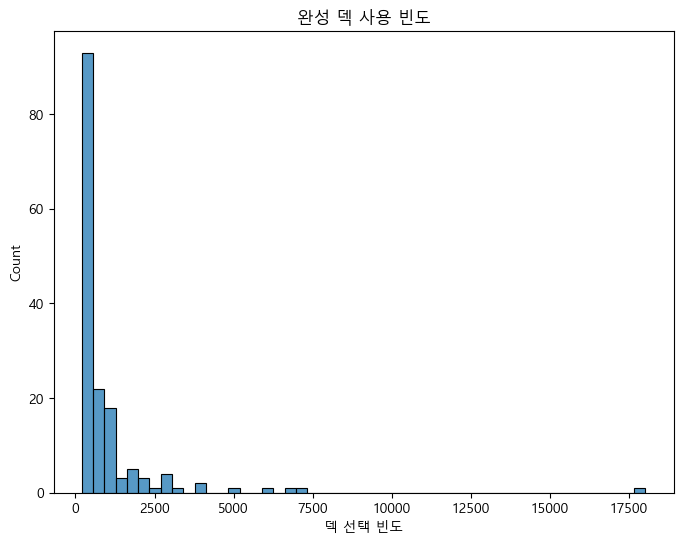

In [ ]:
# 덱 선택 빈도
plt.figure(figsize=(8,6))

sns.histplot(
    data = result_df,
    x='count',
    bins= 50
    )
plt.title('완성 덱 사용 빈도')
plt.xlabel('덱 선택 빈도')
plt.show()

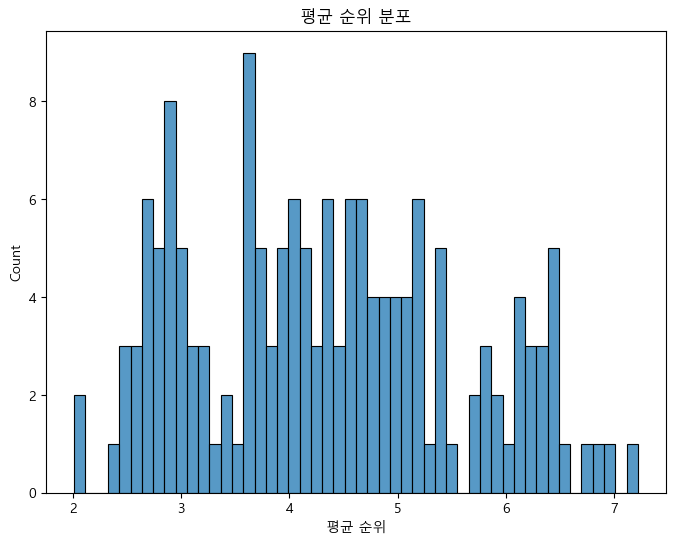

In [ ]:
# 평균 순위 분포
plt.figure(figsize=(8,6))

sns.histplot(
    data = result_df,
    x='mean_ranked',
    bins= 50
    )
plt.title('평균 순위 분포')
plt.xlabel('평균 순위')
plt.show()

11.37
22.42


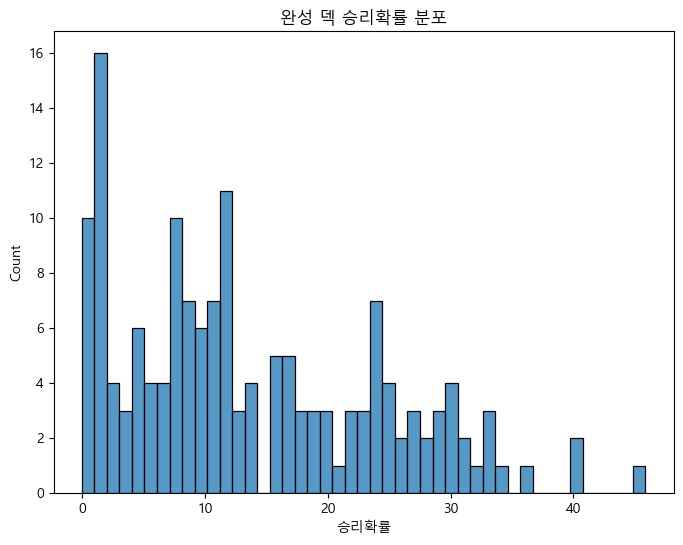

In [ ]:
print(result_df['rank1_ratio'].quantile(0.5))
print(result_df['rank1_ratio'].quantile(0.75))

# 승리 확률 분포
plt.figure(figsize=(8,6))

sns.histplot(
    data = result_df,
    x='rank1_ratio',
    bins= 45
    )
plt.title('완성 덱 승리확률 분포')
plt.xlabel('승리확률')
plt.show()

53.29
71.56


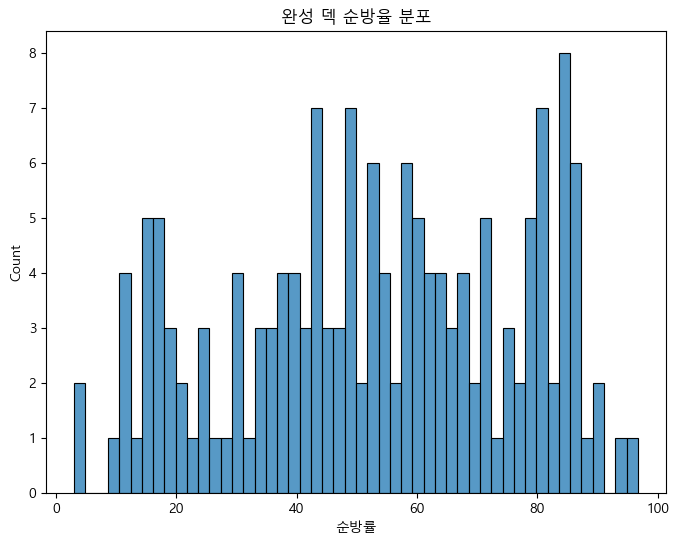

In [ ]:
print(result_df['top4_ratio'].quantile(0.5))
print(result_df['top4_ratio'].quantile(0.75))
# 순방율 빈도
plt.figure(figsize=(8,6))

sns.histplot(
    data = result_df,
    x='top4_ratio',
    bins= 50
    )
plt.title('완성 덱 순방율 분포')
plt.xlabel('순방률')
plt.show()

21.0
24.0
27.0


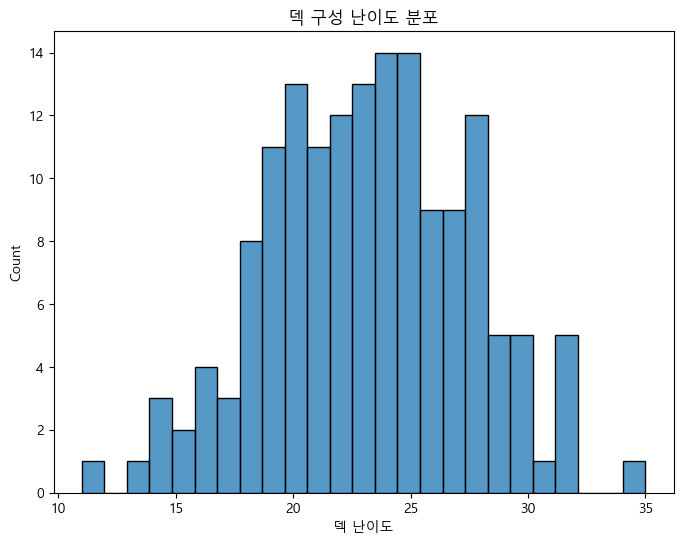

In [ ]:
print(result_df['entry_cost'].quantile(0.3))
print(result_df['entry_cost'].quantile(0.6))
print(result_df['entry_cost'].quantile(0.8))

# 덱구성 난이도 분포
plt.figure(figsize=(8,6))

sns.histplot(
    data = result_df,
    x='entry_cost',
    bins= 25
    )
plt.title('덱 구성 난이도 분포')
plt.xlabel('덱 난이도')
plt.show()

In [ ]:
result_df.to_csv('TFT_Deck_list.csv')